In [ ]:
!pip install pandas numpy plotly matplotlib seaborn --quiet

In [37]:
import pandas as pd
import numpy as np
import requests
import json
import time
import re
from datetime import datetime, timedelta
from typing import Dict, List, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
# Disable warnings
import warnings
warnings.filterwarnings('ignore')


# Clinical Terminology

Before jumping into the dataset, lets look at some basic definitions of the common clinical trial terminologies:

![](https://miro.medium.com/max/1400/1*gi_w8mUa3UmZFu86uOILBg.png)

For more information on Clinical Trials related glossary, refer to [this](https://clinicaltrials.gov/ct2/about-studies/glossary) and [this](https://medium.com/@gauravkantgoel/clinical-trials-glossary-6e1b4dc01e0d)

# 1. Exploratory Data Analysis (EDA) and Visualization

**Objective:** Understand the dataset's structure, identify patterns, detect anomalies, and check assumptions using statistical summaries and graphical representations.

In [ ]:
full_data = pd.read_csv('/content/train_data.csv')

In [ ]:
train_df = pd.read_csv('/content/train_data.csv')
test_df = pd.read_csv('/content/test_data.csv')

In [ ]:
train_df.shape

(1053, 30)

In [ ]:
test_df.shape

(288, 29)

In [ ]:
train_df.head(2)

,NCT Number,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Other Outcome Measures,Sponsor,Collaborators,Sex,Age,Phases,Enrollment,Funder Type,Study Type,Study Design,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,Outcome
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,YES,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,Objective Response Rate (ORR) Based on BICR As...,NaN,AstraZeneca,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,713.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,05-07-14,02-13-17,08-24-23,04-29-14,01-30-19,10-10-23,"Research Site, Chandler, Arizona, 85224, Unite...","Study Protocol, https://cdn.clinicaltrials.gov...",Approved
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,YES,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...","Progression Free Survival (PFS), Progression F...",NaN,Bristol-Myers Squibb,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,405.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,12-21-12,02-16-16,12-29-20,11-06-12,03-22-17,04-19-22,"Mayo Clinic, Phoenix, Arizona, 85054, United S...",NaN,Approved


In [ ]:
test_df.head()

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   nct_number                  1053 non-null   object 
 1   study_title                 1053 non-null   object 
 2   study_url                   1053 non-null   object 
 3   acronym                     533 non-null    object 
 4   study_status                1053 non-null   object 
 5   brief_summary               1053 non-null   object 
 6   study_results               1053 non-null   object 
 7   conditions                  1053 non-null   object 
 8   interventions               1053 non-null   object 
 9   primary_outcome_measures    1052 non-null   object 
 10  secondary_outcome_measures  997 non-null    object 
 11  other_outcome_measures      67 non-null     object 
 12  sponsor                     1053 non-null   object 
 13  collaborators               252 n

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   nct_number                  288 non-null    object
 1   study_title                 288 non-null    object
 2   study_url                   288 non-null    object
 3   acronym                     121 non-null    object
 4   study_status                288 non-null    object
 5   brief_summary               288 non-null    object
 6   study_results               288 non-null    object
 7   conditions                  288 non-null    object
 8   interventions               288 non-null    object
 9   primary_outcome_measures    288 non-null    object
 10  secondary_outcome_measures  275 non-null    object
 11  other_outcome_measures      20 non-null     object
 12  sponsor                     288 non-null    object
 13  collaborators               49 non-null     object

Lets rename these columns and follow snake casing

In [ ]:
train_df.columns = train_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^\w_]', '', regex=True)

test_df.columns = test_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^\w_]', '', regex=True)


Explanation:
*   .str.strip() removes leading/trailing spaces.
*   .str.lower() makes all column names lowercase.
*   .str.replace(' ', '_') replaces spaces with underscores.
*   .str.replace(r'[^\w_]', '', regex=True) removes any non-alphanumeric characters (except underscore).



Example:
- Original column: "Primary Outcome Measures"
- Renamed column: "primary_outcome_measures"

In [ ]:
train_df.describe()

,Enrollment
count,1051.000000
mean,549.970504
std,454.162671
min,1.000000
25%,251.000000
50%,457.000000
75%,732.000000
max,4509.000000


In [ ]:
test_df.describe()

,Enrollment
count,288.000000
mean,714.416667
std,789.906698
min,20.000000
25%,363.000000
50%,543.500000
75%,800.000000
max,8000.000000


In [ ]:
train_df.columns

Index(['nct_number', 'study_title', 'study_url', 'acronym', 'study_status',
       'brief_summary', 'study_results', 'conditions', 'interventions',
       'primary_outcome_measures', 'secondary_outcome_measures',
       'other_outcome_measures', 'sponsor', 'collaborators', 'sex', 'age',
       'phases', 'enrollment', 'funder_type', 'study_type', 'study_design',
       'start_date', 'primary_completion_date', 'completion_date',
       'first_posted', 'results_first_posted', 'last_update_posted',
       'locations', 'study_documents', 'outcome'],
      dtype='object')

In [ ]:
test_df.columns

Index(['nct_number', 'study_title', 'study_url', 'acronym', 'study_status',
       'brief_summary', 'study_results', 'conditions', 'interventions',
       'primary_outcome_measures', 'secondary_outcome_measures',
       'other_outcome_measures', 'sponsor', 'collaborators', 'sex', 'age',
       'phases', 'enrollment', 'funder_type', 'study_type', 'study_design',
       'start_date', 'primary_completion_date', 'completion_date',
       'first_posted', 'results_first_posted', 'last_update_posted',
       'locations', 'study_documents'],
      dtype='object')

| **Column Name**              | **Description**                                                                                                               |      |
| ---------------------------- | ----------------------------------------------------------------------------------------------------------------------------- | ---- |
| `NCT Number`                 | Unique identifier for the clinical trial (assigned by ClinicalTrials.gov), e.g., `NCT02125461`.                               |      |
| `Study Title`                | Official title of the clinical trial, usually technical and descriptive of the study's purpose.                               |      |
| `Study URL`                  | Direct URL to the trial's page on ClinicalTrials.gov.                                                                         |      |
| `Acronym`                    | Short abbreviation for the study (if available), e.g., `PACIFIC`.                                                             |      |
| `Study Status`               | The current state of the trial (e.g., `Completed`, `Active`, `Recruiting`, `Terminated`, `Withdrawn`).                        |      |
| `Brief Summary`              | A short paragraph summarizing the study's intent, design, and treatment approach. Often extracted from the protocol.          |      |
| `Study Results`              | Indicates if results are available (`YES`/`NO`) on ClinicalTrials.gov.                                                        |      |
| `Conditions`                 | Diseases, disorders, or health conditions being studied. Usually standardized terms like `Non-Small Cell Lung Cancer`.        |      |
| `Interventions`              | The treatments, drugs, procedures, or placebos used in the study (can be multiple, delimited by \`                            | \`). |
| `Primary Outcome Measures`   | Key outcomes that determine the effectiveness/safety of the intervention (e.g., `Progression-Free Survival`).                 |      |
| `Secondary Outcome Measures` | Additional outcomes of interest (e.g., `Overall Survival`, `Quality of Life`), not primary endpoints.                         |      |
| `Other Outcome Measures`     | Exploratory or less critical outcomes measured in the study.                                                                  |      |
| `Sponsor`                    | Primary organization responsible for conducting the study (often a pharma company, academic institute, or government agency). |      |
| `Collaborators`              | Other organizations or partners involved in the trial.                                                                        |      |
| `Sex`                        | Participant eligibility by gender: `ALL`, `MALE`, `FEMALE`.                                                                   |      |
| `Age`                        | Participant eligibility by age group: e.g., `ADULT`, `CHILD`, `OLDER_ADULT`, or a combination.                                |      |
| `Phases`                     | Clinical trial phase, such as `PHASE1`, `PHASE2`, `PHASE3`, etc. (some trials span multiple phases).                          |      |
| `Enrollment`                 | Target or actual number of participants in the study.                                                                         |      |
| `Funder Type`                | Entity type funding the trial: e.g., `INDUSTRY`, `NIH`, `OTHER`.                                                              |      |
| `Study Type`                 | Type of trial: `INTERVENTIONAL`, `OBSERVATIONAL`, or `EXPANDED ACCESS`.                                                       |      |
| `Study Design`               | Concatenated description of the study’s methodology: e.g., randomization, blinding, intervention model, and primary purpose.  |      |
| `Start Date`                 | Date when the trial officially started recruiting participants.                                                               |      |
| `Primary Completion Date`    | Date when data collection for the primary outcome measure was completed.                                                      |      |
| `Completion Date`            | Date when the trial was fully completed (including secondary outcomes and final data).                                        |      |
| `First Posted`               | When the trial was first registered/listed on ClinicalTrials.gov.                                                             |      |
| `Results First Posted`       | Date when the trial results were first posted (if applicable).                                                                |      |
| `Last Update Posted`         | Most recent update to the trial information.                                                                                  |      |
| `Locations`                  | List of cities/countries where the trial was conducted. Can be extensive for global trials.                                   |      |
| `Study Documents`            | Links to downloadable trial documentation, like protocol PDFs, statistical analysis plans, etc.                               |      |


## Missing value analysis

In [ ]:
missing_values = train_df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

,0
other_outcome_measures,986
collaborators,801
acronym,520
study_documents,471
results_first_posted,246
secondary_outcome_measures,56
locations,36
completion_date,5
primary_completion_date,2
enrollment,2


In [ ]:
missing_values = test_df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

,0
results_first_posted,285
study_documents,285
other_outcome_measures,268
collaborators,239
acronym,167
locations,19
secondary_outcome_measures,13


Text(0.5, 1.0, 'Features with >1% missing data')

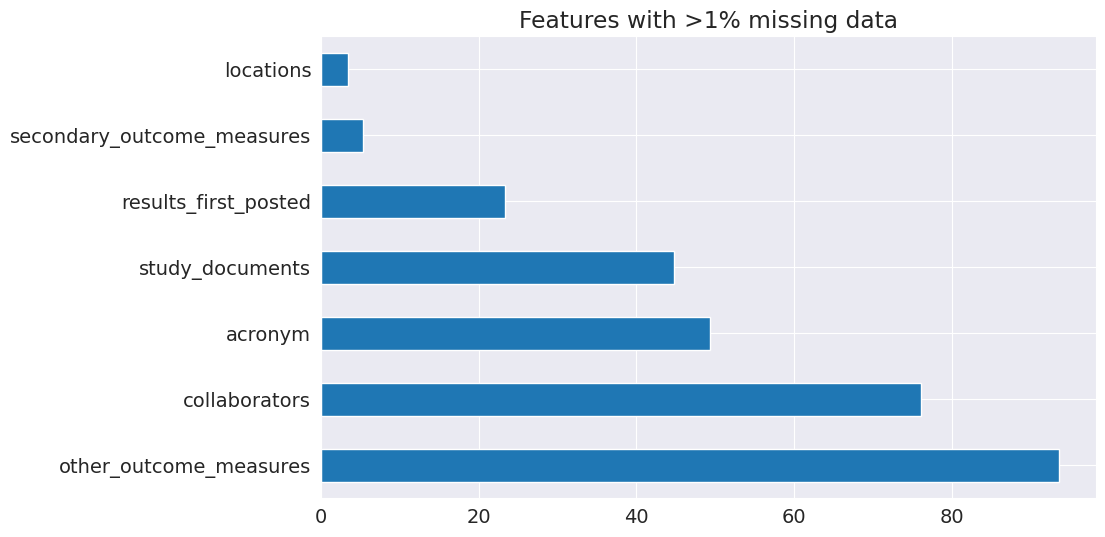

In [ ]:
missing = train_df.isnull().mean().sort_values(ascending=False)*100
missing[missing > 1].plot(kind='barh')
plt.title("Features with >1% missing data")

Text(0.5, 1.0, 'Features with >1% missing data')

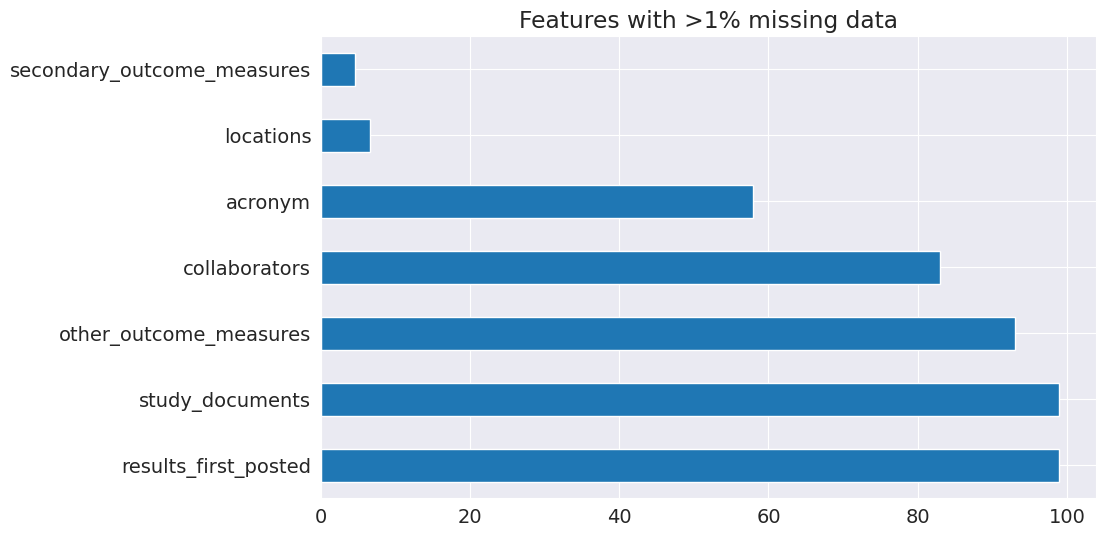

In [ ]:
missing = test_df.isnull().mean().sort_values(ascending=False)*100
missing[missing > 1].plot(kind='barh')
plt.title("Features with >1% missing data")

Most missingness is concentrated in:

- Other Outcome Measures (~90%)

- Collaborators (~75%)

- Acronym, Study Documents, Results First Posted (~20–40%)

Implications:
- Actionable strategy per field:

 - Other Outcome Measures: likely ignorable or use a binary flag (has_other_outcomes)

 - Collaborators: flag or impute as "None" if truly empty

 - Acronym: non-essential, drop

 - Study Documents: can be used as a proxy for transparency (binary: has docs)

 - Results First Posted: binary (has_results_posted) may be predictive of outcome maturity

## Data Visualization

Lets try visualizing all the columns and how they are related to target column.



```
# Histogram for numerical features
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

#histogram for categorical features
px.histogram(raw_df, x='column', title='column vs. target', color='target')

```

### Temporal trends
Lets try to visualize both training and test dataset to understand how trials are distributed with respect to year

**Training dataset**

In [ ]:
# Create histogram
fig = px.histogram(train_df, x=pd.to_datetime(train_df['start_date'], format='mixed', errors='coerce').dt.year, title='No. of Rows per Year train dataset')
# Add space between bars
fig.update_layout(bargap=0.2)
fig.show()

**Test dataset**

In [ ]:
# Create histogram
fig = px.histogram(test_df, x=pd.to_datetime(test_df['start_date'], format='mixed', errors='coerce').dt.year, title='No. of Rows per Year test dataset')
# Add space between bars
fig.update_layout(bargap=0.2)
fig.show()

**Insight:**

**Train Dataset**
- Covers a broad range: ~2000 to 2024

- Highly imbalanced over time:

- Sparse data from 2000–2009

- Sharp rise from 2010

- Peak around 2014–2017

- Gradual decline after 2018

**Test Dataset**
- Mostly includes data from 2018 to 2025

- Very recent-heavy, no older data before ~2014

- Distribution skews heavily toward newer years (esp. post-2020)

**Random splits** would leak temporal patterns and invalidate the evaluation.

### Trial Outcome vs Year

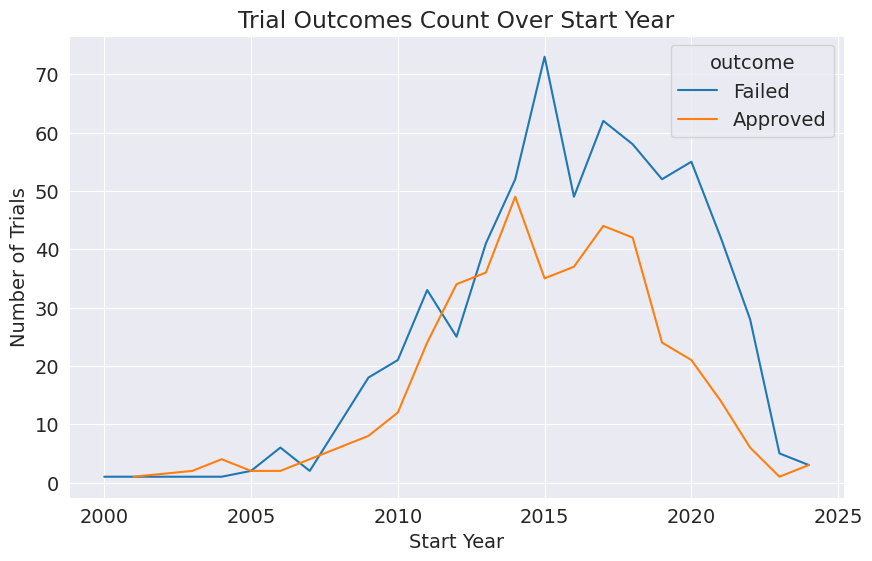

In [ ]:
# Drop rows where 'Start Year' could not be extracted (NaN)
df_hist = train_df.dropna(subset=['start_year'])

# Group by 'Start Year' and 'Outcome' and count the occurrences
outcome_counts_by_year = df_hist.groupby(['start_year', 'outcome']).size().reset_index(name='Count')

# Plot the counts over time using seaborn.lineplot
# 'Start Year' is on the x-axis and the computed 'Count' is on the y-axis,
# with lines separated by 'Outcome'.
sns.lineplot(data=outcome_counts_by_year, x='start_year', y='Count', hue='outcome')
plt.title('Trial Outcomes Count Over Start Year')
plt.ylabel('Number of Trials')
plt.xlabel('Start Year')
plt.show()

Insight:
- Sharp increase in trials post-2010, peaking between 2015–2019.

- Both approvals and failures follow similar growth, but failures consistently outnumber approvals.

- Post-2020 drop is likely due to data lag — many recent trials may still be ongoing.

Implications:
- For modeling: trials started in recent years may not have complete outcomes → risk of label leakage or incomplete supervision.

- Possible feature idea: trial age or duration as proxy for maturity.

- We should Consider excluding trials started after 2020 if many are censored or mislabeled.

### Study Type vs Approval

In [ ]:
train_df['study_type'].value_counts()

,count
study_type,
INTERVENTIONAL,698


In [ ]:
test_df['study_type'].value_counts()

,count
study_type,
INTERVENTIONAL,288


In [ ]:
px.histogram(train_df, x='study_type', title='Study Type vs. target', color='outcome')

- There is 40% positive approvals and 60% failed trials which is the overall approval rate in training data there isn't any other category so we can drop this column.
- All study type are interventional we dont see any relation hence it can be dropped.

### Overall Approval Rate

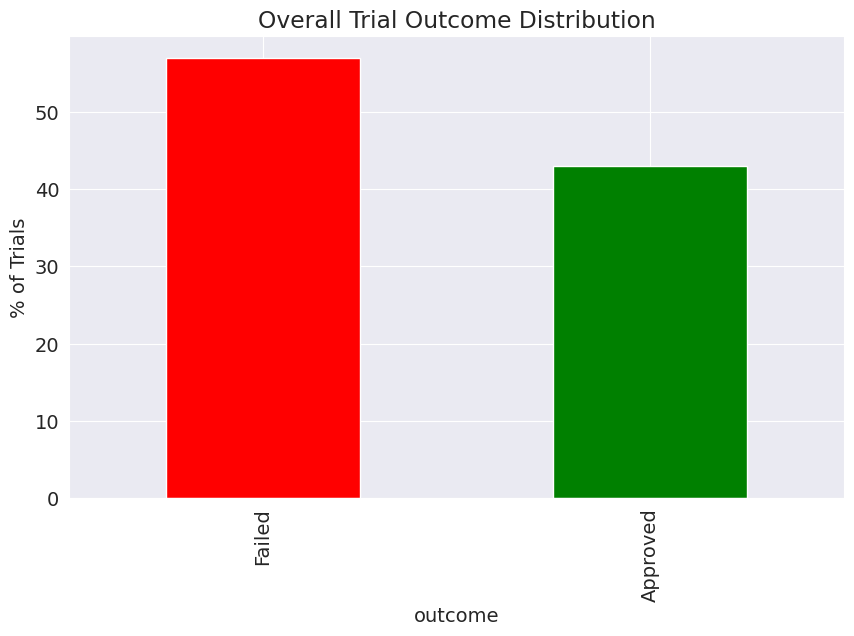

In [ ]:
approved_pct = train_df['outcome'].value_counts(normalize=True) * 100
approved_pct.plot(kind='bar', color=['red', 'green'])
plt.title("Overall Trial Outcome Distribution")
plt.ylabel("% of Trials")
plt.show()

Insight:

Around 60% of historical trials failed, and only 40% succeeded.

This highlights a class imbalance, which is typical in real-world clinical trial data.

Implications:

Modeling will need to account for imbalance — need to use metrics like ROC AUC, precision/recall, or calibrated probabilities.

Can’t rely solely on accuracy; a naive model predicting “fail” for all trials would be 60% accurate but useless.

> Why Imbalanced Data is a Problem?

When one class dominates (e.g., Failures), a model can get high accuracy by doing almost nothing:

**Example:**

> Imagine a dumb model that always predicts "Fail":


Accuracy = 60% — just by predicting the majority class

But it never detects successful trials (the actual valuable cases!)

So this model is useless in practice, even though accuracy seems “good”

**Why These Metrics Are Better:**
1. ROC AUC (Area Under Curve)
Measures how well the model separates approved vs. failed trials

 -  Insensitive to class imbalance

 -  0.5 = random guess, 1.0 = perfect separation

2. Precision / Recall / F1
 - Focus on true positive quality

 - Important when false negatives (missing good drugs) or false positives (approving bad ones) are costly

| Metric    | What It Tells You                        |
| --------- | ---------------------------------------- |
| Precision | When model says “Approved,” is it right? |
| Recall    | Of all true “Approved,” how many found?  |
| F1 Score  | Balance between Precision & Recall       |


**Why Calibrated Probabilities?**
We’ll be using the predicted probabilities as PTS scores

If model is overconfident or underconfident, the PTS % won’t be meaningful

Calibrated classifiers ensure the predicted probability = real-world likelihood

> For example:

If the model assigns 80% PTS to 100 trials, about 80 of them should really succeed.

This is crucial in risk-based decision-making in clinical development.

### Trial outcome vs Phase

In [ ]:
train_df['phases'].value_counts()

,count
phases,
PHASE3,694
PHASE2|PHASE3,3
PHASE2,1


In [ ]:
val_df['phases'].value_counts()

,count
phases,
PHASE3,131
PHASE2|PHASE3,1


In [ ]:
test_df['phases'].value_counts()

,count
phases,
PHASE3,46


In [ ]:
import plotly.express as px

fig = px.bar(
    train_df,
    x='phases',
    color='outcome',
    title='Trial Outcome Counts by Phase',
    color_discrete_map={'Approved': 'green', 'Failed': 'red'},
    barmode='group',  # Use 'group' if you want side-by-side bars
)

fig.update_layout(
    xaxis_title='Phase',
    yaxis_title='Number of Trials',
    legend_title='Trial Outcome',
    bargap=0.2
)

fig.show()


Insight:

- There are almost 99% phase 3 trials in training dataset, val and test setts
- lets just skip other classes and can drop this column.


### Top Sponsors vs outcome

In [ ]:
train_df['sponsor'].value_counts().nlargest(20)

,count
sponsor,
Hoffmann-La Roche,62
Novartis Pharmaceuticals,46
AstraZeneca,41
Bristol-Myers Squibb,41
Merck Sharp & Dohme LLC,28
"Janssen Research & Development, LLC",24
Pfizer,21
Amgen,17
AbbVie,16


Sorted Plotly Histogram by Total Trials per Sponsor

In [ ]:
# Step 1: Get top sponsors sorted by total count
top_sponsors = (
    train_df['sponsor']
    .value_counts()
    .nlargest(10)
    .index
)

# Step 2: Filter and order data
df_top = train_df[train_df['sponsor'].isin(top_sponsors)]
sponsor_order = (
    df_top['sponsor']
    .value_counts()
    .loc[top_sponsors]
    .index.tolist()
)

# Step 3: Plot sorted histogram
fig = px.histogram(
    df_top,
    x='sponsor',
    color='outcome',
    barmode='group',
    title='Trial Outcome Count by Top 10 Sponsors (Sorted)',
    category_orders={'sponsor': sponsor_order}
)

fig.update_layout(
    xaxis_title='Sponsor',
    yaxis_title='Number of Trials',
    bargap=0.2
)

fig.show()

**Normalized Outcome Distribution per Sponsor(share of success/failure per sponsor.)**

In [ ]:
# Step 1: Get top sponsors sorted by total count
top_sponsors = (
    train_df['sponsor']
    .value_counts()
    .nlargest(10)
    .index
)

# Step 2: Filter and order data
df_top = train_df[train_df['sponsor'].isin(top_sponsors)]
sponsor_order = (
    df_top['sponsor']
    .value_counts()
    .loc[top_sponsors]
    .index.tolist()
)

# Step 3: Plot sorted histogram
fig = px.histogram(
    df_top,
    x='sponsor',
    color='outcome',
    barmode='stack',
    barnorm='percent',
    title='Normalized Outcome Distribution per Sponsor(share of success/failure per sponsor.)',
    category_orders={'sponsor': sponsor_order}
)

fig.update_layout(
    xaxis_title='Sponsor',
    yaxis_title='Number of Trials',
    bargap=0.2
)

fig.show()

 **Observations**

1. **Hoffmann-La Roche**:

   * Has the **highest number of total trials**.
   * **More failures** than approvals → success rate may be lower than average.

2. **Novartis Pharmaceuticals**:

   * Fairly **balanced outcome distribution**, with slightly more approvals than failures.
   * Strong performance relative to its trial volume.

3. **AstraZeneca & Bristol-Myers Squibb**:

   * Similar number of trials and outcomes.
   * **Moderate success rate**—neither clearly dominant nor underperforming.

4. **Merck, Janssen, Pfizer**:

   * Each has fewer trials than the top 3, but **Pfizer and Janssen** show a **higher proportion of approvals**.
   * This might suggest **greater efficiency or selectivity** in the trials they run.

5. **Amgen, AbbVie, Eli Lilly**:

   * Fewer trials overall.
   * Approvals and failures are quite close in number, with **Eli Lilly having a slightly better ratio**.

**Implications**

* **Trial Efficiency**:

  * Sponsors like **Pfizer and Janssen** may be achieving higher **success rates per trial**. Their **smaller trial count** but relatively strong approvals suggest **more effective trial design** or **better candidate selection**.

* **Hoffmann-La Roche**:

  * Their high number of failures may warrant deeper investigation — perhaps due to **higher trial risk appetite**, focus on **challenging therapeutic areas**, or **aggressive pipeline strategy**.

* **Sponsor Strategy Segmentation**:

  * Consider grouping sponsors by their **approval ratio** instead of just trial count, for better performance assessment.



We can try generating some more visuals like:
- Approval Rate per Sponsor – a bar chart showing percentage of approvals.

- Number of Trials Over Time per Sponsor – to capture sponsor activity trends.


In [ ]:
# Step 1: Get top sponsors sorted by total count
top_sponsors = (
    train_df['sponsor']
    .value_counts()
    .nlargest(10)
    .index
)

# Step 2: Filter to top sponsors
df_top = train_df[train_df['sponsor'].isin(top_sponsors)]

# Step 3: Group by sponsor and outcome
outcome_counts = (
    df_top
    .groupby(['sponsor', 'outcome'])
    .size()
    .unstack(fill_value=0)
)

# Optional: Ensure consistent column naming
outcome_counts = outcome_counts.rename(columns=lambda x: str(x).lower())

# Step 4: Compute success rate
# Assuming 'approved' and 'failed' are the only outcomes (adjust names if different)
outcome_counts['success_rate'] = outcome_counts['approved'] / (outcome_counts['approved'] + outcome_counts['failed'])

# Step 5: Reset index if needed
success_rate_df = outcome_counts[['success_rate']].reset_index()

# Display the result
print(success_rate_df)


outcome                              sponsor  success_rate
0                                     AbbVie      0.375000
1                                      Amgen      0.411765
2                                AstraZeneca      0.463415
3                       Bristol-Myers Squibb      0.463415
4                      Eli Lilly and Company      0.642857
5                          Hoffmann-La Roche      0.306452
6        Janssen Research & Development, LLC      0.708333
7                    Merck Sharp & Dohme LLC      0.571429
8                   Novartis Pharmaceuticals      0.521739
9                                     Pfizer      0.666667


In [ ]:
px.bar(success_rate_df, x='sponsor', y='success_rate')

Janssen has highest approval rate of around 70 % followed by pfizer 66% then lily 64% and then merck 57% and novartis 52%.

Roche has lowest approval rate 30%

### Sponsor Approval Rate Data

This is really helpful lets just create a sponsor approval rate dataset on full data that we can use later in feature engineering.**bold text**

In [ ]:
# Step 1: Get top sponsors sorted by total count
top_sponsors = (
    train_df['sponsor']
    .value_counts()
    .index
)

# Step 2: Filter to top sponsors
df_top = train_df[train_df['sponsor'].isin(top_sponsors)]

# Step 1: Group by sponsor and outcome
outcome_counts = (
    df_top
    .groupby(['sponsor', 'outcome'])
    .size()
    .unstack(fill_value=0)
)

# Optional: Ensure consistent column naming
outcome_counts = outcome_counts.rename(columns=lambda x: str(x).lower())

# Step 4: Compute success rate
# Assuming 'approved' and 'failed' are the only outcomes (adjust names if different)
outcome_counts['success_rate'] = outcome_counts['approved'] / (outcome_counts['approved'] + outcome_counts['failed'])

# Step 5: Reset index if needed
success_rate_df = outcome_counts[['success_rate']].reset_index()

# Display the result
print(success_rate_df)


outcome                                            sponsor  success_rate
0                                               AB Science      0.000000
1                              ACADIA Pharmaceuticals Inc.      0.333333
2                                         AEterna Zentaris      0.000000
3                                     AGC Biologics S.p.A.      0.000000
4                          ALK-AbellÃƒÆ’Ã†â€™Ãƒâ€šÃ‚Â³ A/S      0.000000
..                                                     ...           ...
282                                              Veru Inc.      0.000000
283                                 Xcovery Holdings, Inc.      1.000000
284      Zogenix International Limited, Inc., a subsidi...      1.000000
285                                             medac GmbH      1.000000
286                                         pharmaand GmbH      0.333333

[287 rows x 2 columns]


In [ ]:
# #finally write it to a dataset to use later
# success_rate_df.to_csv("/content/sponsor_approval_rate.csv", index=False)

### Approval % by Top 10 Conditions

In [ ]:
train_df['conditions'].value_counts()


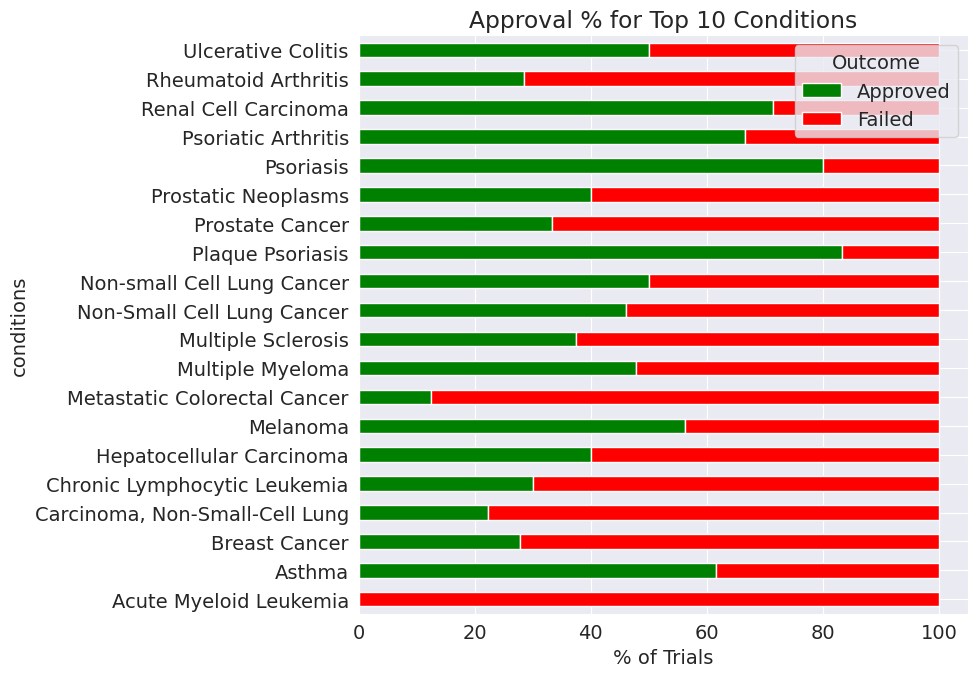

In [ ]:
# Get top 10 conditions
top_conditions = train_df['conditions'].value_counts().nlargest(20).index

# Filter
df_top_cond = train_df[train_df['conditions'].isin(top_conditions)]

# Group and plot
cond_group = df_top_cond.groupby('conditions')['outcome'].value_counts(normalize=True).unstack().fillna(0) * 100

cond_group.plot(kind='barh', stacked=True, figsize=(10, 7), color=['green', 'red'])
plt.title("Approval % for Top 10 Conditions")
plt.xlabel("% of Trials")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()


Insight:

There's significant variance in approval rates by condition:

Psoriasis, Asthma, and Multiple Myeloma show higher approval (~50–70%).

Colorectal Cancer, Melanoma, and NSCLC show lower approval (~10–30%).

Some condition names are duplicated with variations (e.g., Non-Small Cell Lung Cancer vs. Non-small Cell Lung Cancer vs. Carcinoma, Non-Small-Cell Lung).

Implications:

Therapeutic Area (TA) or condition is a strong predictor of trial success.

We can Normalize similar condition names.

We could engineer a Therapeutic Area -level baseline approval rate as a feature.

May be useful to group conditions into high-risk vs. low-risk or by therapeutic domain.

### Enrollment Distribution

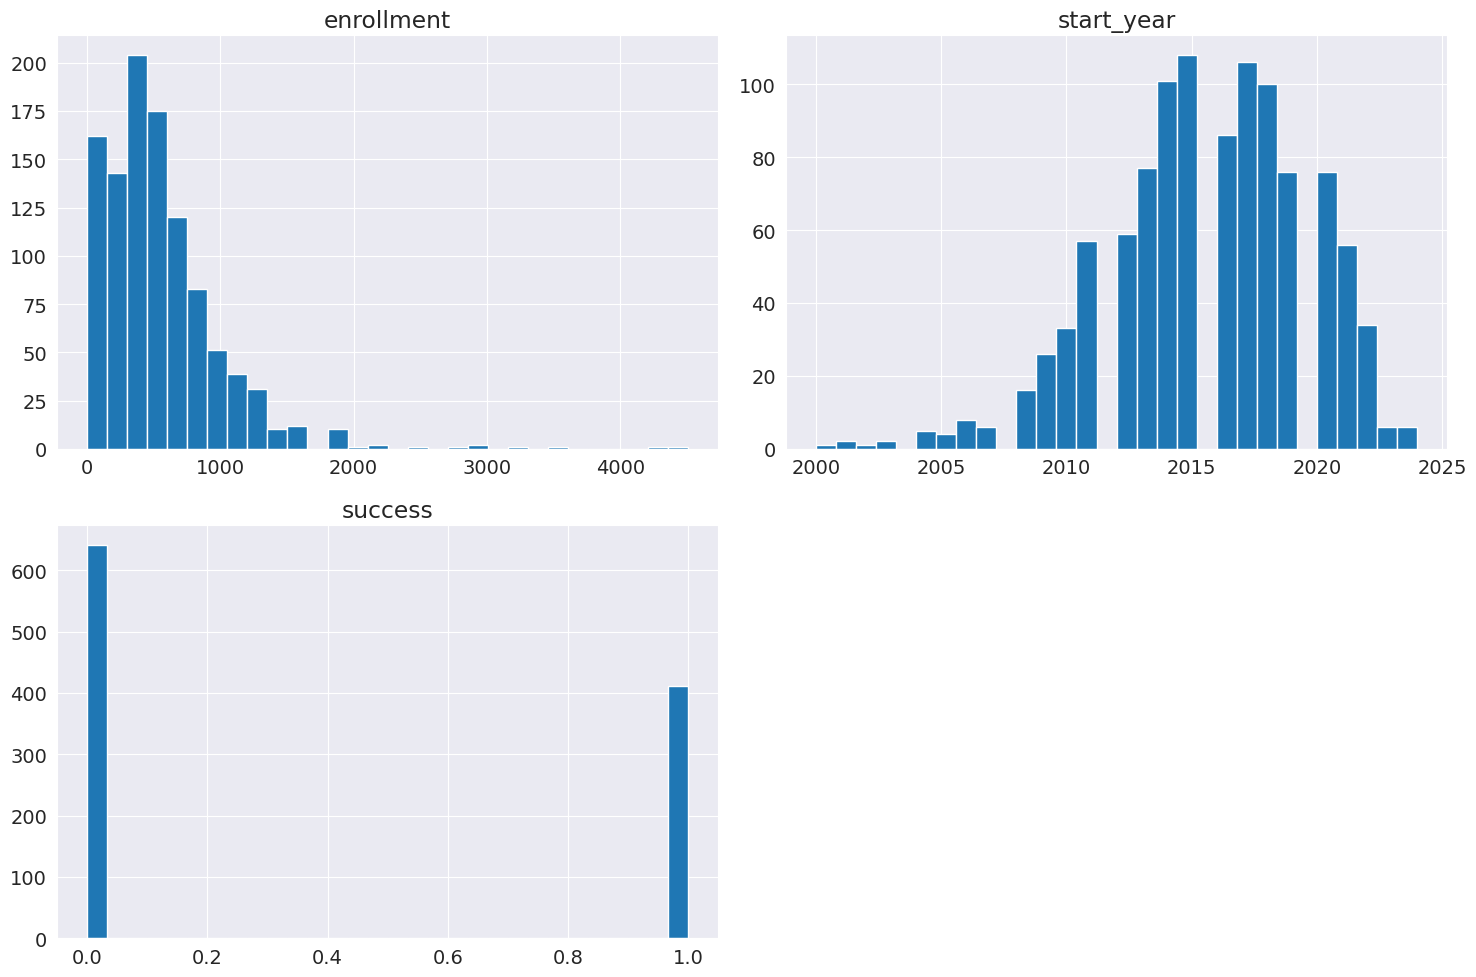

In [ ]:
train_df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

## Study status Analysis
Study status can be either of the following:
-   **Not yet recruiting:**  The study has not started recruiting participants.
-   **Recruiting:**  The study is currently recruiting participants.
-   **Enrolling by invitation:**  The study is selecting its participants from a population, or group of people, decided on by the researchers in advance. These studies are not open to everyone who meets the eligibility criteria but only to people in that particular population, who are specifically invited to participate.
-   **Active, not recruiting:**  The study is ongoing, and participants are receiving an intervention or being examined, but potential participants are not currently being recruited or enrolled.
-   **Suspended:**  The study has stopped early but may start again.
-   **Terminated:**  The study has stopped early and will not start again. Participants are no longer being examined or treated.
-   **Completed:**  The study has ended normally, and participants are no longer being examined or treated (that is, the last participant's last visit has occurred).
-   **Withdrawn:**  The study stopped early, before enrolling its first participant.
-   **Unknown:**  A study on ClinicalTrials.gov whose last known status was recruiting; not yet recruiting; or active, not recruiting but that has passed its completion date, and the status has not been  last verified  within the past 2 years.

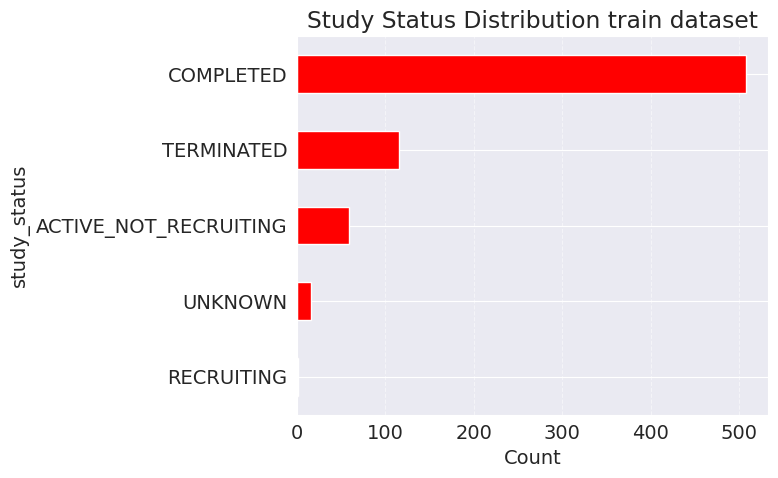

In [ ]:
train_df['study_status'].value_counts().sort_values().plot.barh(
    color='red',
    figsize=(8, 5),
    title='Study Status Distribution train dataset'
  )
plt.xlabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

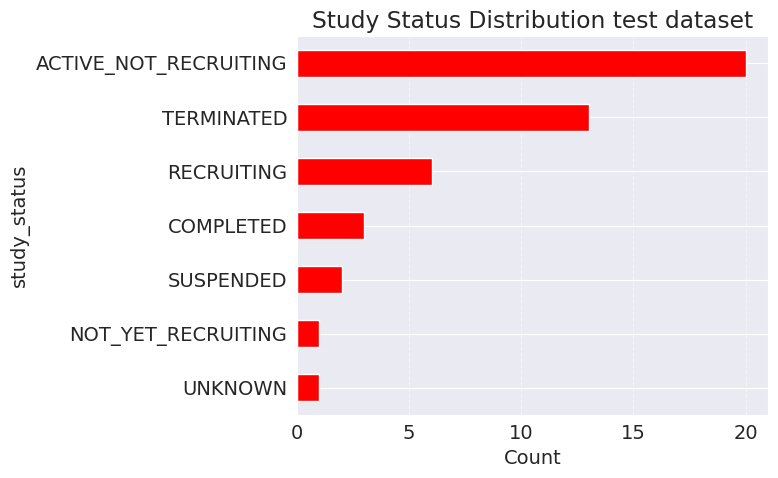

In [ ]:
test_df['study_status'].value_counts().sort_values().plot.barh(
    color='red',
    figsize=(8, 5),
    title='Study Status Distribution test dataset'
  )
plt.xlabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Data Imbalance:

The train set is highly imbalanced toward the COMPLETED label.

The test set is more balanced but still skewed, though differently — top label is ACTIVE_NOT_RECRUITING.

Distribution Shift (Train vs Test):

Models trained on this skewed train data may struggle to generalize on the test set where labels are more diverse.

Might cause poor prediction for underrepresented classes in training (RECRUITING, SUSPENDED, etc.).

Potential Action Points:

We will have to assign class weights during training.

Can Consider label grouping (e.g., combining similar statuses).

Will have to monitor per-class metrics (precision, recall) and not just accuracy.

## Study Types

Describes the nature of a clinical study. Study types include :

### Interventional studies (also called clinical trials),

A type of clinical study in which participants are assigned to groups that receive one or more intervention/treatment (or no intervention) so that researchers can evaluate the effects of the interventions on biomedical or health-related outcomes. The assignments are determined by the study's protocol. Participants may receive diagnostic, therapeutic, or other types of interventions.


### Observational studies (including patient registries),

A type of clinical study in which participants are identified as belonging to study groups and are assessed for biomedical or health outcomes. Participants may receive diagnostic, therapeutic, or other types of interventions, but the investigator does not assign participants to a specific interventions/treatment.
A patient registry is a type of observational study.

### Expanded access.

A way for patients with serious diseases or conditions who cannot participate in a clinical trial to gain access to a medical product that has not been approved by the U.S. Food and Drug Administration (FDA). Also called compassionate use. There are different expanded access types.

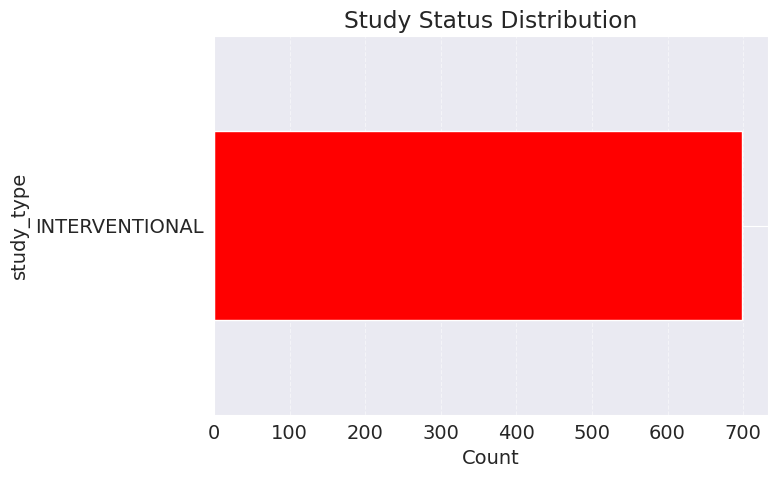

In [ ]:
train_df['study_type'].value_counts().sort_values().plot.barh(
    color='red',
    figsize=(8, 5),
    title='Study Status Distribution'
  )
plt.xlabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

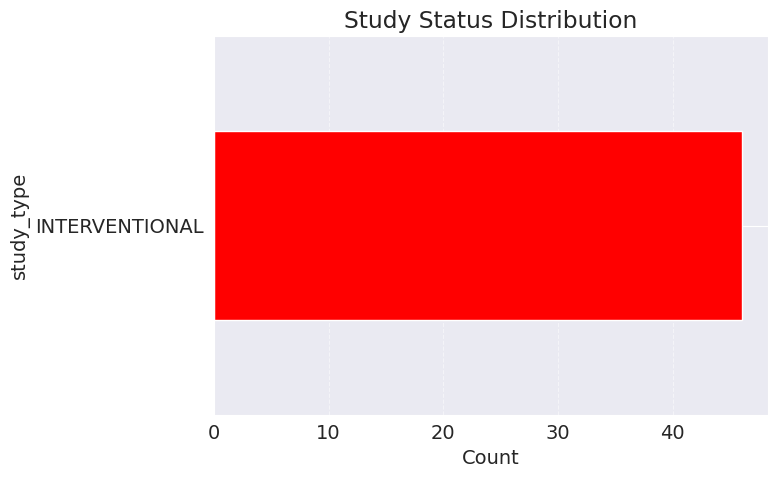

In [ ]:
test_df['study_type'].value_counts().sort_values().plot.barh(
    color='red',
    figsize=(8, 5),
    title='Study Status Distribution'
  )
plt.xlabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

All of these are Interventional study type there aren't any other groups so we can drop this column as it wont have any effect on predictions.

## Interventions given

Intervention refers to the medicinal product (e.g drug, device, vaccine, placebo etc) given to the patients in a study. Let’s see the top five interventions given in these studies.

In [ ]:
train_df['interventions'].value_counts().sort_values(ascending=True)

,count
interventions,
BIOLOGICAL: pembrolizumab|DRUG: placebo,1
DRUG: Abiraterone acetate|DRUG: Prednisone|OTHER: Androgen deprivation therapy (ADT)|DRUG: Abiraterone acetate Placebo|DRUG: Prednisone Placebo,1
DRUG: Lapatinib|DRUG: Trastuzumab|DRUG: Aromatase Inhibitor|DRUG: Lapatinib,1
BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG: Carboplatin|DRUG: Paclitaxel,1
DRUG: Nivolumab|DRUG: Temozolomide|RADIATION: Radiotherapy,1
...,...
DRUG: Masitinib|DRUG: Placebo,2
DRUG: Apatinib|DRUG: Placebo,2
BIOLOGICAL: Nivolumab|DRUG: Docetaxel,2


<ipython-input-64-236935619>:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


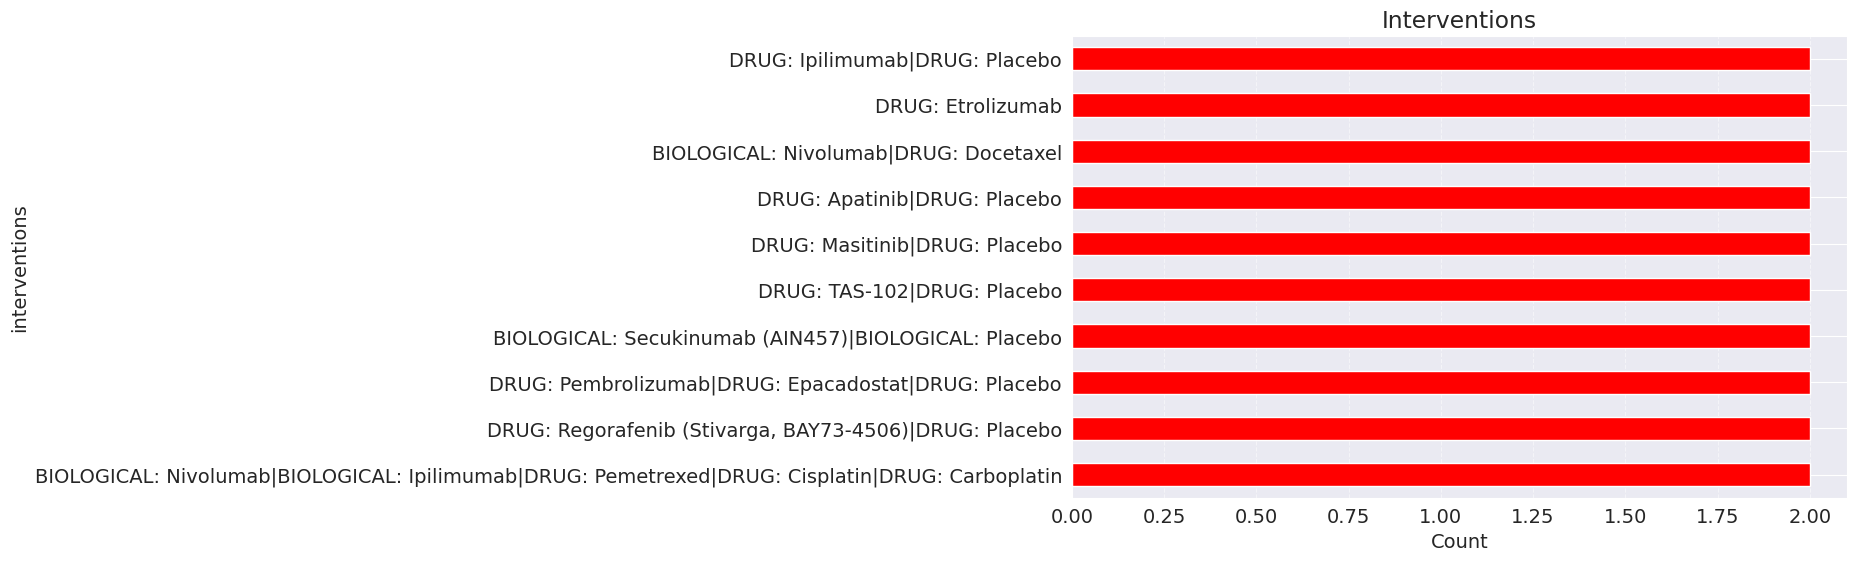

In [ ]:
top_interventions = train_df['interventions'].value_counts().sort_values(ascending=True)[-10:]
top_interventions.plot.barh(
    color='red',
    title='Interventions'
  )
plt.xlabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
top_interventions

,count
interventions,
BIOLOGICAL: Nivolumab|BIOLOGICAL: Ipilimumab|DRUG: Pemetrexed|DRUG: Cisplatin|DRUG: Carboplatin,2
"DRUG: Regorafenib (Stivarga, BAY73-4506)|DRUG: Placebo",2
DRUG: Pembrolizumab|DRUG: Epacadostat|DRUG: Placebo,2
BIOLOGICAL: Secukinumab (AIN457)|BIOLOGICAL: Placebo,2
DRUG: TAS-102|DRUG: Placebo,2
DRUG: Masitinib|DRUG: Placebo,2
DRUG: Apatinib|DRUG: Placebo,2
BIOLOGICAL: Nivolumab|DRUG: Docetaxel,2
DRUG: Etrolizumab,2


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

**Intervention count distribution vs. outcome**

<ipython-input-69-1450519852>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['n_interventions'] = train_df['interventions'].str.count(r'\|') + 1


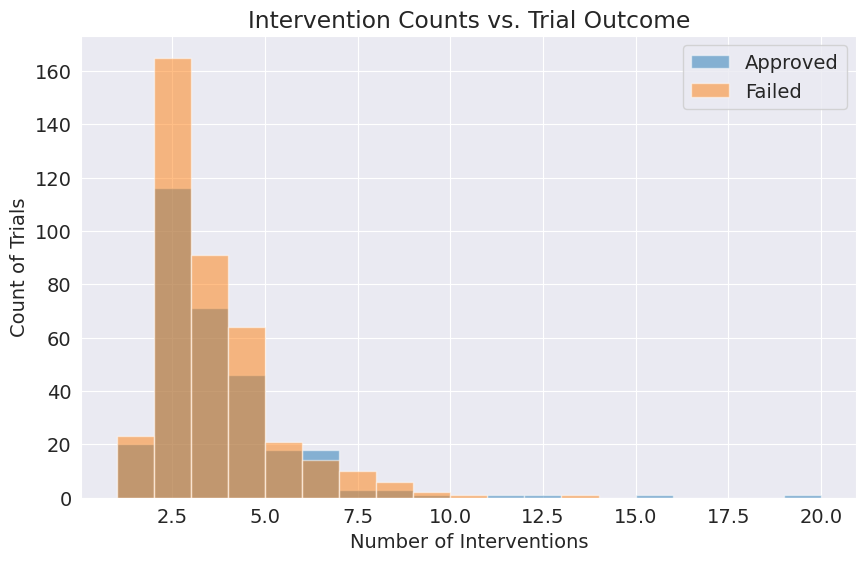

In [ ]:
train_df['n_interventions'] = train_df['interventions'].str.count(r'\|') + 1

plt.figure()
for outcome in train_df['outcome'].unique():
    subset = train_df[train_df['outcome'] == outcome]
    plt.hist(subset['n_interventions'],
             bins=range(1, train_df['n_interventions'].max()+2),
             alpha=0.5,
             label=outcome)
plt.xlabel('Number of Interventions')
plt.ylabel('Count of Trials')
plt.legend()
plt.title('Intervention Counts vs. Trial Outcome')
plt.show()

**Success rate by modality complexity**

In [ ]:
def modality_types(interv):
    return set(i.split(':')[0] for i in interv.split('|'))

train_df['modality_count'] = train_df['interventions'].apply(lambda x: len(modality_types(x)))
train_df['modality_category'] = train_df['modality_count'].map({
    1: 'Single-modality',
    2: 'Bi-modality'
}).fillna('Multi-modality')

modality_stats = (
    train_df
    .groupby('modality_category')
    .agg(
        total_trials=('nct_number','count'),
        success_count=('outcome', lambda s: (s=='Approved').sum())
    )
    .assign(success_rate=lambda d: d['success_count'] / d['total_trials'])
    .reset_index()
)
print(modality_stats)

  modality_category  total_trials  success_count  success_rate
0       Bi-modality           124             55      0.443548
1    Multi-modality            20              8      0.400000
2   Single-modality           554            237      0.427798


<ipython-input-71-2837448818>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['modality_count'] = train_df['interventions'].apply(lambda x: len(modality_types(x)))
<ipython-input-71-2837448818>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['modality_category'] = train_df['modality_count'].map({


**Clustering interventions via TF-IDF**

In [ ]:
tfidf = TfidfVectorizer(min_df=5, ngram_range=(1,2))
X = tfidf.fit_transform(train_df['interventions'].fillna(''))

kmeans = KMeans(n_clusters=5, random_state=0)
train_df['cluster'] = kmeans.fit_predict(X)

<ipython-input-73-1986148883>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cluster'] = kmeans.fit_predict(X)


In [ ]:
train_df['cluster']

,cluster
0,4
1,3
3,4
4,4
5,0
...,...
1045,0
1047,0
1049,4
1051,4


Interventions has lot of unstructure data its better we split this data into multiple categorical columns and do one hot encoding on it.

## Study Results

In [ ]:
train_df['study_results'].value_counts()

,count
study_results,
YES,807
NO,246


Lets make this numerical column by mapping yes->1 and no -> 0

In [ ]:
train_df['study_results'] = train_df['study_results'].replace({"YES": 1, "NO": 0})

In [ ]:
test_df['study_results'] = train_df['study_results'].replace({"YES": 1, "NO": 0})

## Collaborators

In [ ]:
train_df['collaborators'].value_counts()

,count
collaborators,
Ono Pharmaceutical Co. Ltd,17
Merck Sharp & Dohme LLC,10
Sanofi,9
Eisai Inc.,9
AbbVie,6
"Merck KGaA, Darmstadt, Germany",6
GlaxoSmithKline,6
Bristol-Myers Squibb,5
"Genentech, Inc.",4


In [ ]:
# Step 1: Get top sponsors sorted by total count
top_sponsors = (
    train_df['collaborators']
    .value_counts()
    .nlargest(20)
    .index
)

# Step 2: Filter and order data
df_top = train_df[train_df['collaborators'].isin(top_sponsors)]
sponsor_order = (
    df_top['collaborators']
    .value_counts()
    .loc[top_sponsors]
    .index.tolist()
)

# Step 3: Plot sorted histogram
fig = px.histogram(
    df_top,
    x='collaborators',
    color='outcome',
    barmode='group',
    title='Trial Outcome Count by Top 10 collaborators (Sorted)',
    category_orders={'sponsor': sponsor_order}
)

fig.update_layout(
    xaxis_title='collaborators',
    yaxis_title='Number of Trials',
    bargap=0.2
)

fig.show()

## Sex

In [ ]:
train_df['sex'].value_counts()

,count
sex,
ALL,933
FEMALE,79
MALE,40


In [ ]:
px.bar(train_df, x='sex')

## Age

In [ ]:
train_df['age'].value_counts()

,count
age,
"ADULT, OLDER_ADULT",895
"CHILD, ADULT, OLDER_ADULT",74
CHILD,34
ADULT,30
"CHILD, ADULT",14
OLDER_ADULT,6


In [ ]:
px.bar(train_df, x='age')

## Funder Type

In [ ]:
train_df['funder_type'].value_counts()

,count
funder_type,
INDUSTRY,1028
OTHER,13
NETWORK,7
NIH,5


In [ ]:
px.bar(train_df, x='funder_type')

## Study Design

In [ ]:
train_df['study_design'].value_counts()

,count
study_design,
Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: NONE|Primary Purpose: TREATMENT,382
"Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: QUADRUPLE (PARTICIPANT, CARE_PROVIDER, INVESTIGATOR, OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT",285
"Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (PARTICIPANT, INVESTIGATOR)|Primary Purpose: TREATMENT",149
"Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: TRIPLE (PARTICIPANT, CARE_PROVIDER, INVESTIGATOR)|Primary Purpose: TREATMENT",59
Allocation: NA|Intervention Model: SINGLE_GROUP|Masking: NONE|Primary Purpose: TREATMENT,57
"Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: TRIPLE (PARTICIPANT, INVESTIGATOR, OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT",42
Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: SINGLE (OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT,20
Allocation: RANDOMIZED|Intervention Model: CROSSOVER|Masking: NONE|Primary Purpose: TREATMENT,6
Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE|Primary Purpose: TREATMENT,6


In [ ]:
# Step 1: Get top sponsors sorted by total count
top_sponsors = (
    train_df['study_design']
    .value_counts()
    .nlargest(10)
    .index
)

# Step 2: Filter and order data
df_top = train_df[train_df['study_design'].isin(top_sponsors)]
sponsor_order = (
    df_top['study_design']
    .value_counts()
    .loc[top_sponsors]
    .index.tolist()
)

# Step 3: Plot sorted histogram
fig = px.histogram(
    df_top,
    x='study_design',
    color='outcome',
    barmode='group',
    title='Trial Outcome Count by Top 10 study_design (Sorted)',
    category_orders={'study_design': sponsor_order}
)

fig.update_layout(
    xaxis_title='study_design',
    yaxis_title='Number of Trials',
    bargap=0.2
)

fig.show()

# Feature Engineering

In [ ]:
feat_df = train_df.copy()

In [ ]:
feat_df.columns

Index(['nct_number', 'study_title', 'study_url', 'acronym', 'study_status',
       'brief_summary', 'study_results', 'conditions', 'interventions',
       'primary_outcome_measures', 'secondary_outcome_measures',
       'other_outcome_measures', 'sponsor', 'collaborators', 'sex', 'age',
       'phases', 'enrollment', 'funder_type', 'study_type', 'study_design',
       'start_date', 'primary_completion_date', 'completion_date',
       'first_posted', 'results_first_posted', 'last_update_posted',
       'locations', 'study_documents', 'outcome'],
      dtype='object')

In [ ]:
feat_df['outcome'] = feat_df['outcome'].replace({"Approved": 1, "Failed": 0})

## Study Status Features

Group statuses based on their implications:

In [ ]:
def map_status_group(status):
    status = status.upper()
    if status == 'COMPLETED':
        return 'APPROVED'
    elif status in ['TERMINATED', 'WITHDRAWN', 'SUSPENDED']:
        return 'FAILED'
    elif 'RECRUITING' in status or 'ACTIVE' in status:
        return 'ONGOING'
    else:
        return 'UNKNOWN'

feat_df['status_group'] = feat_df['study_status'].map(map_status_group)


In [ ]:
feat_df.head(2)

,nct_number,study_title,study_url,acronym,study_status,brief_summary,study_results,conditions,interventions,primary_outcome_measures,secondary_outcome_measures,other_outcome_measures,sponsor,collaborators,sex,age,phases,enrollment,funder_type,study_type,study_design,start_date,primary_completion_date,completion_date,first_posted,results_first_posted,last_update_posted,locations,study_documents,outcome,status_group
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,1,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,Objective Response Rate (ORR) Based on BICR As...,NaN,AstraZeneca,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,713.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,05-07-14,02-13-17,08-24-23,04-29-14,01-30-19,10-10-23,"Research Site, Chandler, Arizona, 85224, Unite...","Study Protocol, https://cdn.clinicaltrials.gov...",1,APPROVED
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,1,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...","Progression Free Survival (PFS), Progression F...",NaN,Bristol-Myers Squibb,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,405.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,12-21-12,02-16-16,12-29-20,11-06-12,03-22-17,04-19-22,"Mayo Clinic, Phoenix, Arizona, 85054, United S...",NaN,1,APPROVED


## Timeline Features

In [ ]:
def parse_dates(df, date_cols):
    """
    Convert date columns to datetime and compute derived durations.
    date_cols: dict mapping new feature names to tuple(original_col, ref_col)
    e.g., { 'duration_days': ('StartDate', 'CompletionDate') }
    """
    for feat, (col1, col2) in date_cols.items():
        df[col1] = pd.to_datetime(df[col1], errors='coerce')
        df[col2] = pd.to_datetime(df[col2], errors='coerce')
        df[feat] = min(0,(df[col2] - df[col1]).dt.days)
    # Extract year/month for StartDate
    df['start_year'] = df['start_date'].dt.year
    df['start_month'] = df['start_date'].dt.month
    return df

In [ ]:
date_cols = {
    'duration_days': ('start_date', 'completion_date'),
    'time_to_primary_days': ('start_date', 'primary_completion_date'),
    'time_to_start': ('start_date', 'first_posted'),
    'time_to_results': ('start_date', 'results_first_posted'),
    'time_to_last_update': ('start_date', 'last_update_posted')
}
feat_df = parse_dates(feat_df, date_cols)

In [ ]:
# def create_date_features(df: pd.DataFrame) -> pd.DataFrame:
#         """Create date-based features"""

#         # Convert dates
#         date_columns = [ 'Start Date', 'Primary Completion Date', 'Completion Date',
#                         'First Posted', 'Results First Posted', 'Last Update Posted']

#         for col in date_columns:
#             if col in df.columns:
#                 df[col] = pd.to_datetime(df[col], errors='coerce')

#         # Study duration
#         df['StudyDuration'] = (df['Completion Date'] - df['Start Date']).dt.days
#         df['StudyDuration'] = df['StudyDuration'].fillna(df['StudyDuration'].median())

#         # Time to start from submission
#         df['TimeToStart'] = (df['Start Date'] - df['First Posted']).dt.days
#         df['TimeToStart'] = df['TimeToStart'].fillna(df['TimeToStart'].median())

#         # Start year (as proxy for regulatory environment)
#         df['StartYear'] = df['Start Date'].dt.year
#         df['StartYear'] = df['StartYear'].fillna(df['StartYear'].median())

#         # Recent study indicator
#         df['IsRecentStudy'] = (df['StartYear'] >= 2020).astype(int)

#         return df

In [ ]:
feat_df = create_date_features(feat_df)

In [ ]:
feat_df.head(2)

,nct_number,study_title,study_url,acronym,study_status,brief_summary,study_results,conditions,interventions,primary_outcome_measures,secondary_outcome_measures,other_outcome_measures,sponsor,collaborators,sex,age,phases,enrollment,funder_type,study_type,study_design,start_date,primary_completion_date,completion_date,first_posted,results_first_posted,last_update_posted,locations,study_documents,outcome,status_group,duration_days,time_to_primary_days,time_to_start,time_to_results,time_to_last_update,start_year,start_month
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,1,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,Objective Response Rate (ORR) Based on BICR As...,NaN,AstraZeneca,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,713.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,2014-05-07,2017-02-13,2023-08-24,2014-04-29,2019-01-30,2023-10-10,"Research Site, Chandler, Arizona, 85224, Unite...","Study Protocol, https://cdn.clinicaltrials.gov...",1,APPROVED,3396.0,1013.0,0.0,1729.0,3443.0,2014.0,5.0
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,1,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...","Progression Free Survival (PFS), Progression F...",NaN,Bristol-Myers Squibb,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,405.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,2012-12-21,2016-02-16,2020-12-29,2012-11-06,2017-03-22,2022-04-19,"Mayo Clinic, Phoenix, Arizona, 85054, United S...",NaN,1,APPROVED,2930.0,1152.0,0.0,1552.0,3406.0,2012.0,12.0


## Sponsor features

In [ ]:
feat_df['sponsor'].value_counts()

,count
sponsor,
Hoffmann-La Roche,87
Novartis Pharmaceuticals,66
Merck Sharp & Dohme LLC,62
AstraZeneca,60
Bristol-Myers Squibb,56
...,...
InflaRx GmbH,1
"Gustave Roussy, Cancer Campus, Grand Paris",1
"Biosplice Therapeutics, Inc.",1


### Sponsor Track record(from historical trials)

In [ ]:
# Compute sponsor approval rate
sponsor_stats = (
    feat_df.groupby("sponsor")["outcome"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)
sponsor_stats.columns = ["fail_rate", "sponsor_approval_rate"]
sponsor_stats.head()

,fail_rate,sponsor_approval_rate
sponsor,,
AB Science,1.000000,0.000000
ACADIA Pharmaceuticals Inc.,0.666667,0.333333
AEterna Zentaris,1.000000,0.000000
AGC Biologics S.p.A.,1.000000,0.000000
ALK-AbellÃƒÆ’Ã†â€™Ãƒâ€šÃ‚Â³ A/S,1.000000,0.000000


In [ ]:
# Merging this into historical + active datasets
feat_df = feat_df.merge(sponsor_stats[["sponsor_approval_rate"]], on="sponsor", how="left")
feat_df["sponsor_approval_rate"].fillna(sponsor_stats["sponsor_approval_rate"].mean(), inplace=True)

In [ ]:
feat_df.head(2)

,nct_number,study_title,study_url,acronym,study_status,brief_summary,study_results,conditions,interventions,primary_outcome_measures,secondary_outcome_measures,other_outcome_measures,sponsor,collaborators,sex,age,phases,enrollment,funder_type,study_type,study_design,start_date,primary_completion_date,completion_date,first_posted,results_first_posted,last_update_posted,locations,study_documents,outcome,status_group,duration_days,time_to_primary_days,time_to_start,time_to_results,time_to_last_update,start_year,start_month,sponsor_approval_rate
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,1,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,Objective Response Rate (ORR) Based on BICR As...,NaN,AstraZeneca,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,713.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,2014-05-07,2017-02-13,2023-08-24,2014-04-29,2019-01-30,2023-10-10,"Research Site, Chandler, Arizona, 85224, Unite...","Study Protocol, https://cdn.clinicaltrials.gov...",1,APPROVED,3396.0,1013.0,0.0,1729.0,3443.0,2014.0,5.0,0.466667
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,1,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...","Progression Free Survival (PFS), Progression F...",NaN,Bristol-Myers Squibb,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,405.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,2012-12-21,2016-02-16,2020-12-29,2012-11-06,2017-03-22,2022-04-19,"Mayo Clinic, Phoenix, Arizona, 85054, United S...",NaN,1,APPROVED,2930.0,1152.0,0.0,1552.0,3406.0,2012.0,12.0,0.428571


## Location Features

In [ ]:
feat_df['locations'].value_counts()

locations
Osaka, Japan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
feat_df["n_location"] = feat_df["locations"].str.count(r"\|") + 1

In [ ]:
feat_df.head(2)

,nct_number,study_title,study_url,acronym,study_status,brief_summary,study_results,conditions,interventions,primary_outcome_measures,secondary_outcome_measures,other_outcome_measures,sponsor,collaborators,sex,age,phases,enrollment,funder_type,study_type,study_design,start_date,primary_completion_date,completion_date,first_posted,results_first_posted,last_update_posted,locations,study_documents,outcome,status_group,duration_days,time_to_primary_days,time_to_start,time_to_results,time_to_last_update,start_year,start_month,sponsor_approval_rate,n_location
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,1,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,Objective Response Rate (ORR) Based on BICR As...,NaN,AstraZeneca,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,713.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,2014-05-07,2017-02-13,2023-08-24,2014-04-29,2019-01-30,2023-10-10,"Research Site, Chandler, Arizona, 85224, Unite...","Study Protocol, https://cdn.clinicaltrials.gov...",1,APPROVED,3396.0,1013.0,0.0,1729.0,3443.0,2014.0,5.0,0.466667,236.0
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,1,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...","Progression Free Survival (PFS), Progression F...",NaN,Bristol-Myers Squibb,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,405.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,2012-12-21,2016-02-16,2020-12-29,2012-11-06,2017-03-22,2022-04-19,"Mayo Clinic, Phoenix, Arizona, 85054, United S...",NaN,1,APPROVED,2930.0,1152.0,0.0,1552.0,3406.0,2012.0,12.0,0.428571,95.0


## Intervention Feature

In [ ]:
feat_df["interventions"].value_counts()

,count
interventions,
BIOLOGICAL: Pembrolizumab|DRUG: Lenvatinib|DRUG: Placebo for lenvatinib,3
DRUG: SAGE-217|DRUG: Placebo,3
DRUG: Pembrolizumab|DRUG: Epacadostat|DRUG: Placebo,2
DRUG: Ipilimumab|DRUG: Placebo,2
DRUG: Dupilumab|DRUG: Placebo,2
...,...
DRUG: AMG 510|DRUG: Docetaxel,1
DRUG: Azacitidine|DRUG: Conventional Care Regimen,1
BIOLOGICAL: pembrolizumab|DRUG: placebo,1


In [ ]:
def create_intervention_features(df):
    import pandas as pd

    # 1) intervention counts
    df['n_interventions'] = (
        df['interventions']
          .astype(str)
          .str.count(r'\|')
          .add(1)
    )

    # 2) explode to count types
    expl = (
        df[['nct_number','interventions']]
        .assign(
            intervention=lambda d: d['interventions']
                                   .astype(str)
                                   .str.split('|')
        )
        .explode('intervention')
    )
    # Extract the type prefix as a Series
    interv_series = expl['intervention'].astype(str)
    # Use expand=False so we get a Series back
    expl['type'] = interv_series.str.extract(r'^([^:]+):', expand=False).str.strip()

    type_counts = (
        expl.groupby(['nct_number','type'])
             .size()
             .unstack(fill_value=0)
             .add_prefix('n_')
             .reset_index()
    )
    df = df.merge(type_counts, on='nct_number', how='left')

    # 3) presence flags
    df['has_chemotherapy'] = (
        df['interventions']
          .astype(str)
          .str.contains(
             'chemotherapy|cisplatin|doxorubicin|paclitaxel',
             case=False,
             na=False
          )
    )

    # 4) unique interventions
    # strip off the "DRUG:" etc. prefix, lower-case, then count uniques
    expl['drug_name'] = (
        interv_series
          .str.replace(r'^[^:]+:\s*','', regex=True)
          .str.lower()
    )
    unique_counts = (
        expl.groupby('nct_number')['drug_name']
             .nunique()
             .rename('n_unique_interventions')
             .reset_index()
    )
    df = df.merge(unique_counts, on='nct_number', how='left')

    return df


In [ ]:
tmp_df = feat_df.copy()

In [ ]:
feat_df = create_intervention_features(tmp_df)

In [ ]:
feat_df.head(2)

,nct_number,study_title,study_url,acronym,study_status,brief_summary,study_results,conditions,interventions,primary_outcome_measures,secondary_outcome_measures,other_outcome_measures,sponsor,collaborators,sex,age,phases,enrollment,funder_type,study_type,study_design,start_date,primary_completion_date,completion_date,first_posted,results_first_posted,last_update_posted,locations,study_documents,outcome,status_group,duration_days,time_to_primary_days,time_to_start,time_to_results,time_to_last_update,start_year,start_month,sponsor_approval_rate,n_location,n_interventions,n_BIOLOGICAL,n_COMBINATION_PRODUCT,n_DEVICE,n_DIETARY_SUPPLEMENT,n_DRUG,n_GENETIC,n_OTHER,n_PROCEDURE,n_RADIATION,has_chemotherapy,n_unique_interventions
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,1,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,Objective Response Rate (ORR) Based on BICR As...,NaN,AstraZeneca,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,713.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,2014-05-07,2017-02-13,2023-08-24,2014-04-29,2019-01-30,2023-10-10,"Research Site, Chandler, Arizona, 85224, Unite...","Study Protocol, https://cdn.clinicaltrials.gov...",1,APPROVED,3396.0,1013.0,0.0,1729.0,3443.0,2014.0,5.0,0.466667,236.0,2,0,0,0,0,1,0,1,0,0,False,2
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,1,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...","Progression Free Survival (PFS), Progression F...",NaN,Bristol-Myers Squibb,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,405.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,2012-12-21,2016-02-16,2020-12-29,2012-11-06,2017-03-22,2022-04-19,"Mayo Clinic, Phoenix, Arizona, 85054, United S...",NaN,1,APPROVED,2930.0,1152.0,0.0,1552.0,3406.0,2012.0,12.0,0.428571,95.0,4,1,0,0,0,3,0,0,0,0,True,4


## Condition features

### TA approval rate

Lets filter out all conditions in the entire dataset

In [ ]:
# Step 1: Drop missing values
cond_series = train_df['conditions'].dropna()

# Step 2: Split by '|' and flatten the list
all_conditions = cond_series.str.split('|').explode()

# Step 3: Strip whitespace and get unique conditions
unique_conditions = all_conditions.str.strip().dropna().unique()

# Step 4: Convert to a sorted list (optional)
unique_conditions = sorted(unique_conditions)

# View result
print(f"Total unique condition terms: {len(unique_conditions)}")
print(unique_conditions)  # just show a few


Total unique condition terms: 581
['ALK+ Advanced NSCLC', 'ALK-positive NSCLC', 'AML', 'AML Arising From Myelodysplastic Syndrome (MDS)', 'Active Systemic Lupus Erythematosus', 'Acute Lymphoblastic Leukemia', 'Acute Myelogenous Leukemia', 'Acute Myeloid Leukemia', 'Acute Myeloid Leukemia (AML)', 'Acute Myeloid Leukemia With FMS-like Tyrosine Kinase (FLT3) Mutation', 'Acute Repetitive Seizures', 'Adenocarcinoma', 'Adenocarcinoma of the Prostate', 'Adjunctive Treatment of Major Depressive Disorder', 'Adult B Acute Lymphoblastic Leukemia', 'Advanced Angiosarcoma', 'Advanced BRAFV600 Wild-type Melanoma', 'Advanced Breast Cancer', 'Advanced Cancer', 'Advanced Cervical Cancer', 'Advanced Cholangiocarcinoma', 'Advanced Liposarcoma or Leiomyosarcoma', 'Advanced Malignancies', 'Advanced Metastatic Breast Cancer', 'Advanced NET of GI Origin', 'Advanced NET of Lung Origin', 'Advanced Non-squamous Cell Non-small Cell Lung Cancer', 'Advanced Ovarian Cancer', "Advanced Parkinson's Disease", 'Advance

Lets map each of these to therapeutic area

In [ ]:
import pandas as pd

# List of conditions provided
conditions = unique_conditions

# Mapping of therapeutic areas
therapeutic_area_keywords = {
    "Oncology": [
        "cancer", "carcinoma", "neoplasm", "tumor", "sarcoma", "lymphoma", "leukemia",
        "myeloma", "melanoma", "angiosarcoma", "blastoma", "glioma", "mesothelioma",
        "adenocarcinoma", "metastasis", "oncology", "HPV", "sarcomas", "myelodysplastic",
        "GIST", "neuroblastoma", "osteosarcoma", "retinoblastoma", "teratoma", "hepatocellular"
    ],

    "Cardiology": [
        "heart", "cardiac", "cardiovascular", "hypertension", "high blood pressure",
        "arrhythmia", "myocardial", "infarction", "heart failure", "angina", "atherosclerosis",
        "stroke", "valve", "pericarditis", "endocarditis", "tachycardia", "bradycardia",
        "ventricular", "atrial", "ischemia", "heart transplant"
    ],

    "Neurology": [
        "alzheimer", "parkinson", "multiple sclerosis", "ms", "epilepsy", "seizure",
        "stroke", "cerebral", "dementia", "migraine", "neuropathy", "ataxia", "encephalitis",
        "encephalopathy", "ALS", "amyotrophic", "myasthenia gravis", "huntington",
        "guillain", "chorea", "headache", "neurosurgery"
    ],

    "Infectious Diseases": [
        "infection", "infectious", "hiv", "AIDS", "virus", "viral", "bacteria", "bacterial",
        "fungi", "fungal", "parasite", "parasitic", "sepsis", "malaria", "tuberculosis",
        "TB", "influenza", "flu", "covid", "ebola", "zika", "dengue", "hepatitis", "STD",
        "sexually transmitted", "pneumonia", "MRSA"
    ],

    "Endocrinology & Metabolism": [
        "diabetes", "insulin", "metabolic", "metabolism", "thyroid", "goiter", "hyperthyroidism",
        "hypothyroidism", "cushing", "addison", "adrenal", "pituitary", "growth hormone",
        "osteoporosis", "osteopenia", "lipid", "cholesterol", "obesity", "glucose", "pcos",
        "endocrine", "hormone", "hormonal"
    ],

    "Gastroenterology": [
        "gastro", "gastrointestinal", "GI", "colitis", "crohn", "ulcerative", "hepatic",
        "liver", "pancreas", "pancreatitis", "esophagus", "esophagitis", "gastric", "stomach",
        "duodenal", "hepatitis", "cirrhosis", "IBD", "GERD", "acid reflux", "colorectal",
        "constipation", "diarrhea"
    ],

    "Respiratory": [
        "asthma", "copd", "bronch", "bronchitis", "pneumonia", "lung", "pulmonary", "respiratory",
        "emphysema", "tb", "sleep apnea", "sarcoidosis", "cystic fibrosis", "pleurisy",
        "pulmonology", "ARDS", "bronchiectasis"
    ],

    "Musculoskeletal": [
        "arthritis", "rheumatoid", "osteoarthritis", "gout", "osteoporosis", "joints",
        "joint", "muscle", "bursitis", "tendinitis", "tendon", "myopathy", "fibromyalgia",
        "scoliosis", "osteopenia", "spine", "back pain", "skeletal", "orthopedic"
    ],

    "Dermatology": [
        "dermatitis", "eczema", "psoriasis", "pemphigoid", "acne", "rosacea", "vitiligo",
        "melanoma", "skin", "cutaneous", "dermo", "onychomycosis", "pruritus", "urticaria",
        "seborrheic", "pemphigus"
    ],

    "Psychiatry": [
        "depression", "anhedonia", "ptsd", "anxiety", "bipolar", "schizophrenia", "agitation",
        "mania", "psychosis", "obsessive", "compulsive", "OCD", "addiction", "substance use",
        "suicide", "mood disorder", "sleep disorder"
    ],

    "Immunology": [
        "autoimmune", "immune", "immunology", "immunodeficiency", "lupus", "transplant",
        "graft", "GVHD", "cytokine", "inflammation", "allergy", "hypersensitivity",
        "rheumatology", "psoriatic", "crohn", "colitis"
    ],

    "Renal": [
        "renal", "kidney", "nephritis", "nephropathy", "dialysis", "transplant", "glomerular",
        "uremia", "proteinuria", "renal failure", "CKD", "acute kidney injury"
    ],

    "Rheumatology": [
        "arthritis", "rheumatoid", "spondyloarthritis", "ankylosing", "psoriatic",
        "lupus", "vasculitis", "sjogren", "gout", "fibromyalgia", "connective tissue"
    ],

    "Hematology": [
        "leukemia", "lymphoma", "myeloma", "anemia", "hemophilia", "thrombosis", "platelet",
        "erythrocyte", "hematopoietic", "stem cell", "sickle cell", "thalassemia", "bleeding"
    ],

    "Ophthalmology": [
        "eye", "ocular", "vision", "glaucoma", "cataract", "retina", "macular", "uveitis",
        "optic", "ophthalmic", "cornea", "conjunctivitis"
    ],

    "Reproductive Health": [
        "uterine", "ovarian", "prostate", "fallopian", "endometrial", "fertility", "pcos",
        "menopause", "testicular", "cervical", "vaginal", "andropause"
    ],

    "Pain Management": [
        "pain", "analgesic", "opioid", "neuropathic", "chronic pain", "headache", "migraine",
        "fibromyalgia", "arthralgia", "nociceptive", "regional anesthesia", "block"
    ]
}

def map_area(condition):
    cond = condition.lower()
    for area, keywords in therapeutic_area_keywords.items():
        for kw in keywords:
            if kw in cond:
                return area
    return "Other"

# # Build DataFrame
# ta_df = pd.DataFrame({
#     "condition": conditions
# })
# ta_df["therapeutic_area"] = ta_df["condition"].apply(map_area)


In [ ]:
feat_df["therapeutic_area"] = feat_df["conditions"].apply(map_area)

In [ ]:
feat_df['therapeutic_area'].value_counts()

,count
therapeutic_area,
Oncology,747
Neurology,67
Dermatology,60
Other,57
Respiratory,40
Gastroenterology,30
Musculoskeletal,25
Immunology,14
Psychiatry,10


Now we will compute ta approval rate

In [ ]:
area_stats = (
    feat_df
    .groupby('therapeutic_area')['outcome']
    .agg(
        therapeutic_area_approval_rate = 'mean'      # fraction of trials approved
    )
    .reset_index()
)

print(area_stats)


   therapeutic_area  therapeutic_area_approval_rate
0       Dermatology                        0.716667
1  Gastroenterology                        0.533333
2        Immunology                        0.285714
3   Musculoskeletal                        0.480000
4         Neurology                        0.507463
5          Oncology                        0.345382
6             Other                        0.333333
7        Psychiatry                        0.300000
8       Respiratory                        0.500000
9      Rheumatology                        0.666667


In [ ]:
area_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   therapeutic_area                10 non-null     object 
 1   therapeutic_area_approval_rate  10 non-null     float64
dtypes: float64(1), object(1)
memory usage: 292.0+ bytes


In [ ]:
feat_df = feat_df.merge(area_stats, on='therapeutic_area', how='left')

In [ ]:
# def create_condition_features(df: pd.DataFrame) -> pd.DataFrame:
#         """Create condition-related features"""

#         # Therapeutic area classification
#         oncology_keywords = ['cancer', 'tumor', 'carcinoma', 'lymphoma', 'leukemia', 'melanoma', 'sarcoma']
#         neurology_keywords = ['alzheimer', 'parkinson', 'multiple sclerosis', 'epilepsy', 'stroke', 'depression']
#         cardiology_keywords = ['heart', 'cardiac', 'cardiovascular', 'hypertension', 'arrhythmia']
#         diabetes_keywords = ['diabetes', 'diabetic', 'glucose', 'insulin']
#         infectious_keywords = ['infection', 'virus', 'bacterial', 'covid', 'hiv', 'hepatitis']

#         df['IsOncology'] = df['Conditions'].str.contains('|'.join(oncology_keywords), case=False, na=False).astype(int)
#         df['IsNeurology'] = df['Conditions'].str.contains('|'.join(neurology_keywords), case=False, na=False).astype(int)
#         df['IsCardiology'] = df['Conditions'].str.contains('|'.join(cardiology_keywords), case=False, na=False).astype(int)
#         df['IsDiabetes'] = df['Conditions'].str.contains('|'.join(diabetes_keywords), case=False, na=False).astype(int)
#         df['IsInfectious'] = df['Conditions'].str.contains('|'.join(infectious_keywords), case=False, na=False).astype(int)

#         # Rare disease indicator
#         rare_keywords = ['rare', 'orphan', 'ultra-rare']
#         df['IsRareDisease'] = df['Conditions'].str.contains('|'.join(rare_keywords), case=False, na=False).astype(int)

#         # Condition count
#         df['ConditionCount'] = df['Conditions'].str.count('\|') + 1
#         df['ConditionCount'] = df['ConditionCount'].fillna(1)

#         return df

In [ ]:
feat_df.head(2)

,nct_number,study_title,study_url,acronym,study_status,brief_summary,study_results,conditions,interventions,primary_outcome_measures,secondary_outcome_measures,other_outcome_measures,sponsor,collaborators,sex,age,phases,enrollment,funder_type,study_type,study_design,start_date,primary_completion_date,completion_date,first_posted,results_first_posted,last_update_posted,locations,study_documents,outcome,status_group,duration_days,time_to_primary_days,time_to_start,time_to_results,time_to_last_update,start_year,start_month,sponsor_approval_rate,n_location,n_interventions,n_BIOLOGICAL,n_COMBINATION_PRODUCT,n_DEVICE,n_DIETARY_SUPPLEMENT,n_DRUG,n_GENETIC,n_OTHER,n_PROCEDURE,n_RADIATION,has_chemotherapy,n_unique_interventions,therapeutic_area,therapeutic_area_approval_rate
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,1,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,Objective Response Rate (ORR) Based on BICR As...,NaN,AstraZeneca,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,713.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,2014-05-07,2017-02-13,2023-08-24,2014-04-29,2019-01-30,2023-10-10,"Research Site, Chandler, Arizona, 85224, Unite...","Study Protocol, https://cdn.clinicaltrials.gov...",1,APPROVED,3396.0,1013.0,0.0,1729.0,3443.0,2014.0,5.0,0.466667,236.0,2,0,0,0,0,1,0,1,0,0,False,2,Oncology,0.345382
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,1,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...","Progression Free Survival (PFS), Progression F...",NaN,Bristol-Myers Squibb,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,405.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,2012-12-21,2016-02-16,2020-12-29,2012-11-06,2017-03-22,2022-04-19,"Mayo Clinic, Phoenix, Arizona, 85054, United S...",NaN,1,APPROVED,2930.0,1152.0,0.0,1552.0,3406.0,2012.0,12.0,0.428571,95.0,4,1,0,0,0,3,0,0,0,0,True,4,Oncology,0.345382


## Design Features

In [ ]:
feat_df['study_design'].value_counts()

,count
study_design,
Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: NONE|Primary Purpose: TREATMENT,382
"Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: QUADRUPLE (PARTICIPANT, CARE_PROVIDER, INVESTIGATOR, OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT",285
"Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (PARTICIPANT, INVESTIGATOR)|Primary Purpose: TREATMENT",149
"Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: TRIPLE (PARTICIPANT, CARE_PROVIDER, INVESTIGATOR)|Primary Purpose: TREATMENT",59
Allocation: NA|Intervention Model: SINGLE_GROUP|Masking: NONE|Primary Purpose: TREATMENT,57
"Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: TRIPLE (PARTICIPANT, INVESTIGATOR, OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT",42
Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: SINGLE (OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT,20
Allocation: RANDOMIZED|Intervention Model: CROSSOVER|Masking: NONE|Primary Purpose: TREATMENT,6
Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE|Primary Purpose: TREATMENT,6


We can process study design and get following features

| Feature Name             | Type        | Description                                    |
| ------------------------ | ----------- | ---------------------------------------------- |
| `Allocation`             | Categorical | Randomized / Non-randomized / NA               |
| `Intervention Model`     | Categorical | Parallel / Crossover / Single group etc.       |
| `masking_level`          | Categorical | NONE, SINGLE, DOUBLE, etc.                     |
| `masked_*`               | Binary      | Masked roles (participant, investigator, etc.) |
| `Primary Purpose`        | Categorical | Treatment, Prevention, etc.                    |
| `is_randomized_parallel` | Binary      | Composite flag                                 |
| `high_masking`           | Binary      | Flag if masking level is TRIPLE or QUADRUPLE   |


In [ ]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder

def process_study_design(df, column_name='Study Design'):
    df = df.copy()

    # Step 1: Extract fields using regex
    df[['Allocation', 'Intervention Model', 'Masking', 'Primary Purpose']] = df[column_name].str.extract(
        r'Allocation:\s*([^|]*)\|Intervention Model:\s*([^|]*)\|Masking:\s*([^|]*)\|Primary Purpose:\s*(.*)'
    )

    # Step 2: Clean & Normalize
    for col in ['Allocation', 'Intervention Model', 'Masking', 'Primary Purpose']:
        df[col] = df[col].str.strip().fillna('NA').str.upper()

    # Step 3: Extract masking level
    df['masking_level'] = df['Masking'].str.extract(r'^(\w+)').fillna('NA')

    # Step 4: Binary flags for masked roles
    df['masked_participant'] = df['Masking'].str.contains('PARTICIPANT', na=False).astype(int)
    df['masked_care_provider'] = df['Masking'].str.contains('CARE_PROVIDER', na=False).astype(int)
    df['masked_investigator'] = df['Masking'].str.contains('INVESTIGATOR', na=False).astype(int)
    df['masked_outcomes_assessor'] = df['Masking'].str.contains('OUTCOMES_ASSESSOR', na=False).astype(int)

    # Step 5: Composite features
    df['is_randomized_parallel'] = (
        df['Allocation'].eq('RANDOMIZED') & df['Intervention Model'].eq('PARALLEL')
    ).astype(int)

    # Handle high masking with string match (for both encodings)
    df['high_masking'] = df['masking_level'].isin(['TRIPLE', 'QUADRUPLE']).astype(int)

    # Step 6a: Label Encoding (for tree-based models)
    df_label = df.copy()
    label_cols = ['Allocation', 'Intervention Model', 'masking_level', 'Primary Purpose']
    label_encoders = {}
    for col in label_cols:
        le = LabelEncoder()
        df_label[col] = le.fit_transform(df_label[col])
        label_encoders[col] = le  # save encoders if needed later

    label_encoded_cols = ['Allocation', 'Intervention Model', 'masking_level', 'Primary Purpose',
                          'masked_participant', 'masked_care_provider', 'masked_investigator',
                          'masked_outcomes_assessor', 'is_randomized_parallel', 'high_masking']

    df_label_final = df_label[label_encoded_cols]

    # Step 6b: One-Hot Encoding (for linear models)
    df_onehot = df.copy()
    one_hot_cols = ['Allocation', 'Intervention Model', 'masking_level', 'Primary Purpose']
    df_onehot = pd.get_dummies(df_onehot, columns=one_hot_cols, prefix_sep='__')

    onehot_encoded_cols = [col for col in df_onehot.columns if col.startswith(
        ('Allocation__', 'Intervention Model__', 'masking_level__', 'Primary Purpose__'))] + [
        'masked_participant', 'masked_care_provider', 'masked_investigator',
        'masked_outcomes_assessor', 'is_randomized_parallel', 'high_masking'
    ]

    df_onehot_final = df_onehot[onehot_encoded_cols]

    return df_label_final, df_onehot_final, label_encoders


df_label → label encoded features (for tree models like XGBoost, Random Forest)

df_onehot → one-hot encoded features (for logistic regression, SVM, etc.)

encoders → dictionary of fitted LabelEncoders (useful for transforming test data)

In [ ]:
df_label, df_onehot, encoders = process_study_design(feature_engineered_df)

In [ ]:
df_label

,Allocation,Intervention Model,masking_level,Primary Purpose,masked_participant,masked_care_provider,masked_investigator,masked_outcomes_assessor,is_randomized_parallel,high_masking
0,2,3,3,4,1,1,1,1,1,1
1,2,3,2,4,0,0,0,0,1,0
2,2,3,2,4,0,0,0,0,1,0
3,2,3,2,4,0,0,0,0,1,0
4,0,5,2,4,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1048,2,3,3,4,1,1,1,1,1,1
1049,2,3,3,4,1,1,1,1,1,1
1050,2,3,0,4,1,0,1,0,1,0
1051,2,3,5,4,1,1,1,0,1,1


Lets merge the one hot encode columns into feature_engineered_df

# Preparing Data for training

In [ ]:
feat_df.to_csv("feat_df_v2.csv", index=False)

In [4]:
feat_df = pd.read_csv('/content/feat_df_v2.csv')

In [5]:
full_data = feat_df.copy()

## Training, Validation and Test Sets

### **Temporal Split Strategy**

We can Split train data based on time to simulate future unseen data:

- Training:     Data before ~2018
- Validation:   Data from ~2018 to 2022
- Testing:      Provided test set (2023–2025+)

In [6]:
train_df = feat_df[feat_df['start_year'] < 2020]
val_df = feat_df[(feat_df['start_year'] >= 2020) & (feat_df['start_year'] < 2022)]
test_df = feat_df[feat_df['start_year'] >= 2022]

In [7]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (874, 54)
val_df.shape : (132, 54)
test_df.shape : (46, 54)


### Visualization
This looks balanced we can work with this

In [ ]:
# Create histogram
fig = px.histogram(train_df, x=train_df['start_year'], title='No. of Rows per Year train dataset')
# Add space between bars
fig.update_layout(bargap=0.2)


In [ ]:
# Create histogram
fig = px.histogram(val_df, x=val_df['start_year'], title='No. of Rows per Year val dataset')
# Add space between bars
fig.update_layout(bargap=0.2)


In [ ]:
# Create histogram
fig = px.histogram(test_df, x=test_df['start_year'], title='No. of Rows per Year test dataset')
# Add space between bars
fig.update_layout(bargap=0.2)


## Identifying Input and Target Columns

In [8]:
train_df.columns

Index(['nct_number', 'study_title', 'study_url', 'acronym', 'study_status',
       'brief_summary', 'study_results', 'conditions', 'interventions',
       'primary_outcome_measures', 'secondary_outcome_measures',
       'other_outcome_measures', 'sponsor', 'collaborators', 'sex', 'age',
       'phases', 'enrollment', 'funder_type', 'study_type', 'study_design',
       'start_date', 'primary_completion_date', 'completion_date',
       'first_posted', 'results_first_posted', 'last_update_posted',
       'locations', 'study_documents', 'outcome', 'status_group',
       'duration_days', 'time_to_primary_days', 'time_to_start',
       'time_to_results', 'time_to_last_update', 'start_year', 'start_month',
       'sponsor_approval_rate', 'n_location', 'n_interventions',
       'n_BIOLOGICAL', 'n_COMBINATION_PRODUCT', 'n_DEVICE',
       'n_DIETARY_SUPPLEMENT', 'n_DRUG', 'n_GENETIC', 'n_OTHER', 'n_PROCEDURE',
       'n_RADIATION', 'has_chemotherapy', 'n_unique_interventions',
       'therapeuti

In [9]:
input_cols = ['study_status', 'study_results', 'sex', 'age','enrollment',
              'funder_type', 'status_group',
       'duration_days', 'time_to_primary_days', 'time_to_start',
       'time_to_results', 'time_to_last_update', 'start_year', 'start_month',
       'sponsor_approval_rate', 'n_location', 'n_interventions',
       'n_BIOLOGICAL', 'n_COMBINATION_PRODUCT', 'n_DEVICE',
       'n_DIETARY_SUPPLEMENT', 'n_DRUG', 'n_GENETIC', 'n_OTHER', 'n_PROCEDURE',
       'n_RADIATION', 'has_chemotherapy', 'n_unique_interventions',
       'therapeutic_area', 'therapeutic_area_approval_rate']
target_col = 'outcome'

In [10]:
input_cols

['study_status',
 'study_results',
 'sex',
 'age',
 'enrollment',
 'funder_type',
 'status_group',
 'duration_days',
 'time_to_primary_days',
 'time_to_start',
 'time_to_results',
 'time_to_last_update',
 'start_year',
 'start_month',
 'sponsor_approval_rate',
 'n_location',
 'n_interventions',
 'n_BIOLOGICAL',
 'n_COMBINATION_PRODUCT',
 'n_DEVICE',
 'n_DIETARY_SUPPLEMENT',
 'n_DRUG',
 'n_GENETIC',
 'n_OTHER',
 'n_PROCEDURE',
 'n_RADIATION',
 'has_chemotherapy',
 'n_unique_interventions',
 'therapeutic_area',
 'therapeutic_area_approval_rate']

**We can now create inputs and targets for the training, validation and test sets for further processing and model training.**

In [11]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [12]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [13]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [ ]:
train_inputs.head(2)

,study_status,study_results,sex,age,enrollment,funder_type,status_group,duration_days,time_to_primary_days,time_to_start,time_to_results,time_to_last_update,start_year,start_month,sponsor_approval_rate,n_location,n_interventions,n_BIOLOGICAL,n_COMBINATION_PRODUCT,n_DEVICE,n_DIETARY_SUPPLEMENT,n_DRUG,n_GENETIC,n_OTHER,n_PROCEDURE,n_RADIATION,has_chemotherapy,n_unique_interventions,therapeutic_area,therapeutic_area_approval_rate
0,COMPLETED,1,ALL,"ADULT, OLDER_ADULT",713.0,INDUSTRY,APPROVED,3396.0,1013.0,0.0,1729.0,3443.0,2014.0,5.0,0.466667,236.0,2,0,0,0,0,1,0,1,0,0,False,2,Oncology,0.345382
1,COMPLETED,1,ALL,"ADULT, OLDER_ADULT",405.0,INDUSTRY,APPROVED,2930.0,1152.0,0.0,1552.0,3406.0,2012.0,12.0,0.428571,95.0,4,1,0,0,0,3,0,0,0,0,True,4,Oncology,0.345382


In [ ]:
train_targets

,outcome
0,1
1,1
2,1
3,0
4,1
...,...
1047,0
1049,0
1050,1
1051,1


**Let's also identify which of the columns are numerical and which ones are categorical. This will be useful later, as we'll need to convert the categorical data to numbers**

In [14]:
import numpy as np

In [15]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [ ]:
train_inputs[numeric_cols].describe()

,study_results,enrollment,duration_days,time_to_primary_days,time_to_start,time_to_results,time_to_last_update,start_year,start_month,sponsor_approval_rate,n_location,n_interventions,n_BIOLOGICAL,n_COMBINATION_PRODUCT,n_DEVICE,n_DIETARY_SUPPLEMENT,n_DRUG,n_GENETIC,n_OTHER,n_PROCEDURE,n_RADIATION,n_unique_interventions,therapeutic_area_approval_rate
count,874.000000,873.000000,870.000000,873.000000,874.000000,727.000000,874.000000,874.000000,874.000000,874.000000,841.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000
mean,0.831808,577.373425,2058.247126,1284.167239,36.498856,1908.370014,2567.533181,2014.443936,6.911899,0.399232,123.512485,3.154462,0.274600,0.001144,0.011442,0.003432,2.709382,0.002288,0.113272,0.018307,0.020595,3.084668,0.392911
std,0.374251,461.157725,1167.336595,701.623440,285.815203,812.916380,1095.296173,3.361352,3.470744,0.281818,86.812854,1.793506,0.645804,0.033826,0.165410,0.075601,1.727144,0.047809,0.376555,0.150246,0.149950,1.755937,0.102905
min,0.000000,1.000000,63.000000,61.000000,0.000000,510.000000,-211.000000,2000.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.285714
25%,1.000000,295.000000,1184.500000,800.000000,0.000000,1367.000000,1852.750000,2012.000000,4.000000,0.230769,57.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.345382
50%,1.000000,480.000000,1937.000000,1152.000000,0.000000,1751.000000,2447.000000,2015.000000,7.000000,0.428571,114.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.345382
75%,1.000000,748.000000,2750.000000,1614.000000,0.000000,2233.000000,3170.000000,2017.000000,10.000000,0.541667,178.000000,4.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.345382
max,1.000000,4509.000000,8918.000000,4869.000000,6691.000000,6917.000000,8574.000000,2019.000000,12.000000,1.000000,496.000000,19.000000,4.000000,1.000000,3.000000,2.000000,15.000000,1.000000,4.000000,2.000000,2.000000,19.000000,0.716667


In [ ]:
train_inputs[categorical_cols].nunique().sort_values()

,0
sex,3
funder_type,4
status_group,4
study_status,6
age,6
therapeutic_area,10


We will only one hot encode columns where cardinality is less than 10 above that we can look for feature engineering.

In [16]:
categorical_cols = [col for col in train_inputs.select_dtypes(include='object').columns if 1 < train_inputs[col].nunique() <= 10]


In [17]:
categorical_cols

['study_status',
 'sex',
 'age',
 'funder_type',
 'status_group',
 'therapeutic_area']

## Assigning Class Weights in Training

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

classes = train_df['study_status'].unique()
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['study_status'])
class_weight_dict = dict(zip(classes, weights))


In [ ]:
class_weight_dict

{'COMPLETED': np.float64(0.24399776661083195),
 'ACTIVE_NOT_RECRUITING': np.float64(1.4422442244224423),
 'TERMINATED': np.float64(0.9842342342342343),
 'UNKNOWN': np.float64(5.602564102564102),
 'RECRUITING': np.float64(145.66666666666666),
 'ENROLLING_BY_INVITATION': np.float64(145.66666666666666)}

Sample Weight Integration Example (XGBoost):

```
import xgboost as xgb

# Map class weights to training examples
df['sample_weight'] = df['study_status'].map(class_weight_dict)

# Training
model = xgb.XGBClassifier()
model.fit(X_train, y_train, sample_weight=df['sample_weight'])

```



## Imputing Missing Numeric Data

There are several techniques for imputation, but we'll use the most basic one: replacing missing values with the average value in the column using the SimpleImputer class from sklearn.impute.

In [18]:
from sklearn.impute import SimpleImputer

In [19]:
imputer = SimpleImputer(strategy = 'median')

In [20]:
train_inputs[numeric_cols].isna().sum()

,0
study_results,0
enrollment,1
duration_days,4
time_to_primary_days,1
time_to_start,0
time_to_results,147
time_to_last_update,0
start_year,0
start_month,0
sponsor_approval_rate,0


The first step in imputation is to fit the imputer to the data i.e. compute the chosen statistic (e.g. mean, median) for each column in the dataset.

In [21]:
imputer.fit(full_data[numeric_cols])

SimpleImputer(strategy='median')

After calling fit, the computed statistic for each column is stored in the statistics_ property of imputer.

In [ ]:
list(imputer.statistics_)

[np.float64(1.0),
 np.float64(457.0),
 np.float64(1796.5),
 np.float64(1112.0),
 np.float64(0.0),
 np.float64(1675.0),
 np.float64(2205.0),
 np.float64(2016.0),
 np.float64(7.0),
 np.float64(0.4285714285714285),
 np.float64(113.0),
 np.float64(3.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(2.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(3.0),
 np.float64(0.3453815261044177)]

The missing values in the training, test and validation sets can now be filled in using the transform method of imputer.

In [22]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

## Scaling Numeric Features

Let's use MinMaxScaler from sklearn.preprocessing to scale values to the  (0,1)  range.

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler()

First, we fit the scaler to the data i.e. compute the range of values for each numeric column.

In [27]:
scaler.fit(full_data[numeric_cols])

MinMaxScaler()

We can now inspect the minimum and maximum values in each column.

In [28]:
print('Minimum:')
list(scaler.data_min_)

Minimum:


[np.float64(0.0),
 np.float64(1.0),
 np.float64(63.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(448.0),
 np.float64(-242.0),
 np.float64(2000.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.2857142857142857)]

In [29]:
print('Maximum:')
list(scaler.data_max_)

Maximum:


[np.float64(1.0),
 np.float64(4509.0),
 np.float64(8918.0),
 np.float64(4869.0),
 np.float64(6691.0),
 np.float64(6917.0),
 np.float64(8574.0),
 np.float64(2024.0),
 np.float64(12.0),
 np.float64(1.0),
 np.float64(496.0),
 np.float64(19.0),
 np.float64(4.0),
 np.float64(1.0),
 np.float64(3.0),
 np.float64(2.0),
 np.float64(15.0),
 np.float64(1.0),
 np.float64(4.0),
 np.float64(2.0),
 np.float64(2.0),
 np.float64(19.0),
 np.float64(0.7166666666666667)]

We can now separately scale the training, validation and test sets using the transform method of scaler.

In [30]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [31]:
train_inputs[numeric_cols].describe()

,study_results,enrollment,duration_days,time_to_primary_days,time_to_start,time_to_results,time_to_last_update,start_year,start_month,sponsor_approval_rate,...,n_COMBINATION_PRODUCT,n_DEVICE,n_DIETARY_SUPPLEMENT,n_DRUG,n_GENETIC,n_OTHER,n_PROCEDURE,n_RADIATION,n_unique_interventions,therapeutic_area_approval_rate
count,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,...,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000
mean,0.831808,0.127825,0.225189,0.263703,0.005455,0.219681,0.318686,0.601831,0.537445,0.399232,...,0.001144,0.003814,0.001716,0.180625,0.002288,0.028318,0.009153,0.010297,0.115815,0.248744
std,0.374251,0.102243,0.131541,0.144023,0.042716,0.115389,0.124240,0.140056,0.315522,0.281818,...,0.033826,0.055137,0.037801,0.115143,0.047809,0.094139,0.075123,0.074975,0.097552,0.238786
min,0.000000,0.000000,0.000000,0.012528,0.000000,0.009584,0.003516,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.065217,0.126821,0.164613,0.000000,0.155356,0.237608,0.500000,0.272727,0.230769,...,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.000000,0.055556,0.138454
50%,1.000000,0.106145,0.210051,0.236599,0.000000,0.189674,0.305014,0.625000,0.545455,0.428571,...,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.000000,0.111111,0.138454
75%,1.000000,0.165705,0.302710,0.331434,0.000000,0.259507,0.387024,0.708333,0.818182,0.541667,...,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.166667,0.138454
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.791667,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Encoding Categorical Data

Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. A common technique is to use one-hot encoding for categorical columns.

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

One hot encoding involves adding a new binary (0/1) column for each unique category of a categorical column.

In [32]:
train_inputs[categorical_cols].nunique()

,0
study_status,6
sex,3
age,6
funder_type,4
status_group,4
therapeutic_area,10


### OneHotEncoding

We can perform one hot encoding using the OneHotEncoder class from sklearn.preprocessing.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

First, we fit the encoder to the data i.e. identify the full list of categories across all categorical columns.

In [ ]:
encoder.fit(raw_df[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [ ]:
encoder.categories_

[array(['ACTIVE_NOT_RECRUITING', 'COMPLETED', 'ENROLLING_BY_INVITATION',
        'NOT_YET_RECRUITING', 'RECRUITING', 'SUSPENDED', 'TERMINATED',
        'UNKNOWN'], dtype=object),
 array(['NO', 'YES'], dtype=object),
 array(['ALL', 'FEMALE', 'MALE', nan], dtype=object),
 array(['ADULT', 'ADULT, OLDER_ADULT', 'CHILD', 'CHILD, ADULT',
        'CHILD, ADULT, OLDER_ADULT', 'OLDER_ADULT'], dtype=object),
 array(['PHASE2', 'PHASE2|PHASE3', 'PHASE3'], dtype=object),
 array(['INDUSTRY', 'NETWORK', 'NIH', 'OTHER'], dtype=object)]

The encoder has created a list of categories for each of the categorical columns in the dataset.
We can generate column names for each individual category using get_feature_names_out.

In [ ]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Study Status_ACTIVE_NOT_RECRUITING', 'Study Status_COMPLETED', 'Study Status_ENROLLING_BY_INVITATION', 'Study Status_NOT_YET_RECRUITING', 'Study Status_RECRUITING', 'Study Status_SUSPENDED', 'Study Status_TERMINATED', 'Study Status_UNKNOWN', 'Study Results_NO', 'Study Results_YES', 'Sex_ALL', 'Sex_FEMALE', 'Sex_MALE', 'Sex_nan', 'Age_ADULT', 'Age_ADULT, OLDER_ADULT', 'Age_CHILD', 'Age_CHILD, ADULT', 'Age_CHILD, ADULT, OLDER_ADULT', 'Age_OLDER_ADULT', 'Phases_PHASE2', 'Phases_PHASE2|PHASE3', 'Phases_PHASE3', 'Funder Type_INDUSTRY', 'Funder Type_NETWORK', 'Funder Type_NIH', 'Funder Type_OTHER']


All of the above columns will be added to train_inputs, val_inputs and test_inputs.

To perform the encoding, we use the transform method of encoder.

In [ ]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [ ]:
pd.set_option('display.max_columns', None)


In [ ]:
val_inputs.head(2)

,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Other Outcome Measures,Sponsor,Collaborators,Sex,Age,Phases,Enrollment,Funder Type,Study Type,Study Design,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,Study Status_ACTIVE_NOT_RECRUITING,Study Status_COMPLETED,Study Status_ENROLLING_BY_INVITATION,Study Status_NOT_YET_RECRUITING,Study Status_RECRUITING,Study Status_SUSPENDED,Study Status_TERMINATED,Study Status_UNKNOWN,Study Results_NO,Study Results_YES,Sex_ALL,Sex_FEMALE,Sex_MALE,Sex_nan,Age_ADULT,"Age_ADULT, OLDER_ADULT",Age_CHILD,"Age_CHILD, ADULT","Age_CHILD, ADULT, OLDER_ADULT",Age_OLDER_ADULT,Phases_PHASE2,Phases_PHASE2|PHASE3,Phases_PHASE3,Funder Type_INDUSTRY,Funder Type_NETWORK,Funder Type_NIH,Funder Type_OTHER
13,"Study to Compare AMG 510 ""Proposed INN Sotoras...",https://clinicaltrials.gov/study/NCT04303780,NaN,ACTIVE_NOT_RECRUITING,A Phase 3 Study to Compare AMG 510 with Doceta...,YES,"KRAS p, G12c Mutated /Advanced Metastatic NSCLC",DRUG: AMG 510|DRUG: Docetaxel,"Progression-free Survival (PFS), PFS was defin...",NaN,NaN,Amgen,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,0.076309,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,06-04-20,08-02-22,04-27-26,03-11-20,05-10-23,02-25-25,"Pacific Cancer Medical Center Inc, Anaheim, Ca...","Study Protocol, https://cdn.clinicaltrials.gov...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
20,A Study to Assess if BIIB122 Tablets Are Safe ...,https://clinicaltrials.gov/study/NCT05418673,LIGHTHOUSE,TERMINATED,"In this study, researchers will learn more abo...",YES,Parkinson Disease,DRUG: BIIB122|DRUG: BIIB122-Matching Placebo,Time to Confirmed Worsening in Movement Disord...,Number of Participants With Treatment-Emergent...,NaN,Biogen,Denali Therapeutics Inc.,ALL,"ADULT, OLDER_ADULT",PHASE3,0.001331,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,08-26-22,07-27-23,07-27-23,06-14-22,06-26-24,06-26-24,"University of California San Francisco (UCSF),...","Study Protocol and Statistical Analysis Plan, ...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### LabelEncoding

In [33]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def label_encode_dataframe(df: pd.DataFrame, cat_cols: list):
    """
    Label‑encodes the specified categorical columns in df.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    cat_cols : list of str
        List of column names to label‑encode.

    Returns
    -------
    df_encoded : pd.DataFrame
        A copy of df with the specified columns replaced by integer labels.
    encoders : dict
        A mapping {col: fitted LabelEncoder} so you can inverse_transform if needed.
    """
    df_encoded = df.copy()
    encoders = {}

    for col in cat_cols:
        le = LabelEncoder()
        # Fill or drop NaNs as you prefer; here we fill with a placeholder
        df_encoded[col] = df_encoded[col].fillna("UNKNOWN").astype(str)
        df_encoded[col] = le.fit_transform(df_encoded[col])
        encoders[col] = le

    return df_encoded, encoders





```
# Example usage:
# df = pd.read_csv("your_data.csv")
# categorical_columns = ["therapeutic_area", "status_group", "phase"]
# df_encoded, label_encoders = label_encode_dataframe(df, categorical_columns)

# To decode later:
# original = label_encoders["therapeutic_area"].inverse_transform(df_encoded["therapeutic_area"])

```



In [34]:
train_inputs_encoded, train_label_encoders = label_encode_dataframe(train_inputs, categorical_cols)
val_inputs_encoded, val_label_encoders = label_encode_dataframe(val_inputs, categorical_cols)
test_inputs_encoded, test_label_encoders = label_encode_dataframe(test_inputs, categorical_cols)

In [ ]:
train_inputs_encoded.head(2)

,study_status,study_results,sex,age,enrollment,funder_type,status_group,duration_days,time_to_primary_days,time_to_start,time_to_results,time_to_last_update,start_year,start_month,sponsor_approval_rate,n_location,n_interventions,n_BIOLOGICAL,n_COMBINATION_PRODUCT,n_DEVICE,n_DIETARY_SUPPLEMENT,n_DRUG,n_GENETIC,n_OTHER,n_PROCEDURE,n_RADIATION,has_chemotherapy,n_unique_interventions,therapeutic_area,therapeutic_area_approval_rate
0,1,1.0,0,1,713.0,0,0,3396.0,1013.0,0.0,1729.0,3443.0,2014.0,5.0,0.466667,236.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,False,2.0,5,0.345382
1,1,1.0,0,1,405.0,0,0,2930.0,1152.0,0.0,1552.0,3406.0,2012.0,12.0,0.428571,95.0,4.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,True,4.0,5,0.345382


In [ ]:
train_label_encoders

{'study_status': LabelEncoder(),
 'sex': LabelEncoder(),
 'age': LabelEncoder(),
 'funder_type': LabelEncoder(),
 'status_group': LabelEncoder(),
 'therapeutic_area': LabelEncoder()}

## Sampling on Train dataset

In [60]:
from imblearn.over_sampling import SMOTE
import pandas as pd

def apply_smote(X_train: pd.DataFrame, y_train: pd.Series, sampling_strategy: str = 'auto', random_state: int = 42):
    """
    Applies SMOTE to balance class distribution in the training set.

    Parameters:
        X_train (pd.DataFrame): Features of the training set.
        y_train (pd.Series): Labels of the training set.
        sampling_strategy (str or float): Sampling strategy for SMOTE. Default is 'auto'.
        random_state (int): Random seed for reproducibility.

    Returns:
        X_resampled (pd.DataFrame): Resampled training features.
        y_resampled (pd.Series): Resampled training labels.
    """
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    print(f"Before SMOTE: {y_train.value_counts().to_dict()}")
    print(f"After SMOTE: {pd.Series(y_resampled).value_counts().to_dict()}")

    return X_resampled, y_resampled


### Visualization

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_class_distribution(y_before, y_after, labels_map=None, title_suffix=''):
    """
    Plots class distribution before and after SMOTE.

    Parameters:
        y_before (pd.Series or array-like): Target labels before SMOTE.
        y_after (pd.Series or array-like): Target labels after SMOTE.
        labels_map (dict): Optional dictionary to map class labels to human-readable strings.
        title_suffix (str): Optional suffix to append to the plot title.
    """
    y_before = pd.Series(y_before, name='Before SMOTE')
    y_after = pd.Series(y_after, name='After SMOTE')

    df_plot = pd.concat([
        y_before.value_counts().rename_axis('class').reset_index(name='count').assign(phase='Before SMOTE'),
        y_after.value_counts().rename_axis('class').reset_index(name='count').assign(phase='After SMOTE')
    ])

    if labels_map:
        df_plot['class'] = df_plot['class'].map(labels_map)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_plot, x='class', y='count', hue='phase')
    plt.title(f'Class Distribution Before and After SMOTE {title_suffix}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


Before SMOTE: {0: 508, 1: 366}
After SMOTE: {1: 508, 0: 508}


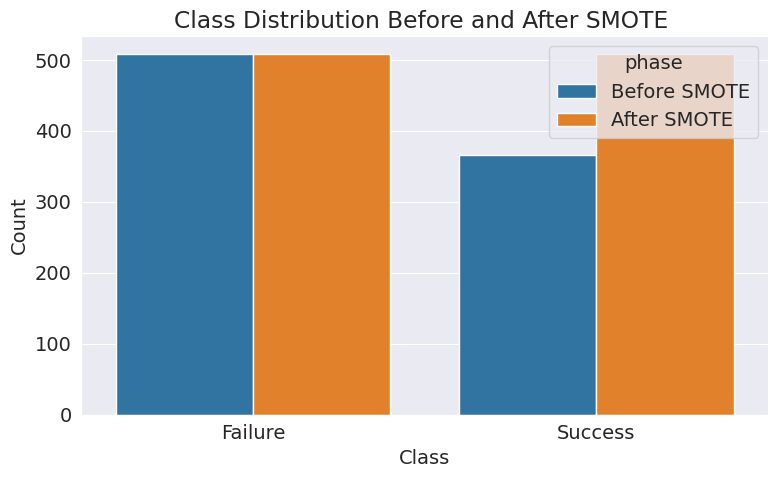

In [62]:
# After applying SMOTE
X_resampled, y_resampled = apply_smote(train_inputs_encoded, train_targets)

# Visualize changes
plot_class_distribution(train_targets, y_resampled, labels_map={0: 'Failure', 1: 'Success'})

# Training and Visualization

## Baseline model

This is a **binary classification** to **regression translation:**

We have **binary labels** (Approved = 1, Failed = 0)

But the real-world task is to estimate the probability of success for unseen trials — which can be interpreted as a PTS score
> In simpler terms:

Train a classifier → Use predicted probabilities as PTS %.

** Train a classifier (e.g., LightGBMClassifier)**
Use binary classification

Predict probability of class 1 (success) → that’s our PTS %


```
PTS % = model.predict_proba(test_X)[:, 1] * 100
```



In [63]:
def create_baseline_model(X_train: pd.DataFrame, y_train: pd.Series):
        """Create a simple baseline model"""
        print("Creating baseline model...")

        # Simple Logistic Regression
        baseline_model = LogisticRegression(random_state=42, max_iter=1000)
        baseline_model.fit(X_train, y_train)

        # Cross-validation
        cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='roc_auc')

        results = {
            'model': baseline_model,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'cv_scores': cv_scores
        }

        print(f"Baseline Model - CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        return results

In [64]:
res = create_baseline_model(train_inputs_encoded, train_targets)

Creating baseline model...
Baseline Model - CV AUC: 0.8909 (+/- 0.0461)


In [80]:
ews_resampled =create_baseline_model(X_resampled, y_resampled)

Creating baseline model...
Baseline Model - CV AUC: 0.8934 (+/- 0.0249)


In [65]:
res['model']

LogisticRegression(max_iter=1000, random_state=42)

## Advance Techniques

### Advanced Models

In [66]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import pandas as pd
import numpy as np

def train_advanced_models(X_train: pd.DataFrame, y_train: pd.Series):
    """
    Trains and tunes advanced models (RandomForest, XGBoost, GradientBoosting) using RandomizedSearchCV.
    Returns a dictionary containing each trained model, cross-validation scores, and feature importances.
    """
    print("Training and tuning advanced models...")
    models = {}

    # Utility: Display and return top feature importances
    def show_feature_importance(model, model_name):
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            importance_df = pd.DataFrame({
                'feature': X_train.columns,
                'importance': importances
            }).sort_values(by='importance', ascending=False)
            print(f"\n{model_name} - Top Feature Importances:")
            print(importance_df.head(10))
            return importance_df
        return None

    # ------------------- RANDOM FOREST -------------------
    rf_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [6, 10, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    }
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_search = RandomizedSearchCV(rf, rf_param_grid, n_iter=10, cv=5,
                                   scoring='roc_auc', random_state=42, n_jobs=-1)
    rf_search.fit(X_train, y_train)
    best_rf = rf_search.best_estimator_
    rf_cv = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='roc_auc')
    models['RandomForest'] = {
        'model': best_rf,
        'cv_mean': rf_cv.mean(),
        'cv_std': rf_cv.std(),
        'feature_importance': show_feature_importance(best_rf, "RandomForest")
    }

    # ------------------- XGBOOST -------------------
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }
    xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
    xgb_search = RandomizedSearchCV(xgb_model, xgb_param_grid, n_iter=10, cv=5,
                                    scoring='roc_auc', random_state=42, n_jobs=-1)
    xgb_search.fit(X_train, y_train)
    best_xgb = xgb_search.best_estimator_
    xgb_cv = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='roc_auc')
    models['XGBoost'] = {
        'model': best_xgb,
        'cv_mean': xgb_cv.mean(),
        'cv_std': xgb_cv.std(),
        'feature_importance': show_feature_importance(best_xgb, "XGBoost")
    }

    # ------------------- GRADIENT BOOSTING -------------------
    gb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }
    gb_model = GradientBoostingClassifier(random_state=42)
    gb_search = RandomizedSearchCV(gb_model, gb_param_grid, n_iter=10, cv=5,
                                   scoring='roc_auc', random_state=42, n_jobs=-1)
    gb_search.fit(X_train, y_train)
    best_gb = gb_search.best_estimator_
    gb_cv = cross_val_score(best_gb, X_train, y_train, cv=5, scoring='roc_auc')
    models['GradientBoosting'] = {
        'model': best_gb,
        'cv_mean': gb_cv.mean(),
        'cv_std': gb_cv.std(),
        'feature_importance': show_feature_importance(best_gb, "GradientBoosting")
    }

    # ------------------- SUMMARY -------------------
    print("\nModel Performance Summary (Tuned Models):")
    for name, result in models.items():
        print(f"{name} - CV AUC: {result['cv_mean']:.4f} (+/- {result['cv_std'] * 2:.4f})")

    return models


In [67]:
advanced_models = train_advanced_models(train_inputs_encoded, train_targets)

Training and tuning advanced models...

RandomForest - Top Feature Importances:
                           feature  importance
14           sponsor_approval_rate    0.253071
7                    duration_days    0.100316
0                     study_status    0.089162
10                 time_to_results    0.067160
11             time_to_last_update    0.065180
4                       enrollment    0.049430
8             time_to_primary_days    0.049271
15                      n_location    0.045167
29  therapeutic_area_approval_rate    0.035856
12                      start_year    0.031903

XGBoost - Top Feature Importances:
                           feature  importance
5                      funder_type    0.137397
0                     study_status    0.131388
14           sponsor_approval_rate    0.114222
6                     status_group    0.080259
29  therapeutic_area_approval_rate    0.060327
1                    study_results    0.049363
23                         n_OTHER    

In [81]:
advanced_models = train_advanced_models(X_resampled, y_resampled)

Training and tuning advanced models...

RandomForest - Top Feature Importances:
                           feature  importance
14           sponsor_approval_rate    0.238740
7                    duration_days    0.087908
0                     study_status    0.072354
11             time_to_last_update    0.065487
10                 time_to_results    0.060383
8             time_to_primary_days    0.057349
4                       enrollment    0.055447
15                      n_location    0.047421
12                      start_year    0.034838
29  therapeutic_area_approval_rate    0.034030

XGBoost - Top Feature Importances:
                           feature  importance
0                     study_status    0.152702
14           sponsor_approval_rate    0.129286
5                      funder_type    0.103208
29  therapeutic_area_approval_rate    0.064424
6                     status_group    0.051686
1                    study_results    0.042458
3                              age    

In [82]:
advanced_models

{'RandomForest': {'model': RandomForestClassifier(min_samples_split=5, n_jobs=-1, random_state=42),
  'cv_mean': np.float64(0.9079308795931496),
  'cv_std': np.float64(0.03104604437791243),
  'feature_importance':                            feature  importance
  14           sponsor_approval_rate    0.238740
  7                    duration_days    0.087908
  0                     study_status    0.072354
  11             time_to_last_update    0.065487
  10                 time_to_results    0.060383
  8             time_to_primary_days    0.057349
  4                       enrollment    0.055447
  15                      n_location    0.047421
  12                      start_year    0.034838
  29  therapeutic_area_approval_rate    0.034030
  13                     start_month    0.033297
  6                     status_group    0.032706
  21                          n_DRUG    0.023671
  16                 n_interventions    0.021086
  27          n_unique_interventions    0.020361
  1 

Goal: Train and fine-tune three powerful ensemble models—Random Forest, XGBoost, and Gradient Boosting—to predict clinical trial success using cross-validation and hyperparameter optimization.

Steps Performed:

- RandomizedSearchCV is used for efficient hyperparameter tuning across a defined parameter grid.

- Cross-validation (CV AUC) is computed for each model to ensure robustness.

- Feature Importances are printed to understand key contributing variables for each model.

Why This Helps:

- Ensures you capture non-linear patterns and interactions using tree-based models.

- Hyperparameter tuning improves model generalization and reduces overfitting.

- Feature importance gives insight into clinical or operational drivers of trial outcomes.

- CV AUC scores let you compare model robustness across multiple folds.

## Ensembling top 3 models

In [69]:
def create_ensemble_model(models: Dict, X_train: pd.DataFrame, y_train: pd.Series):
        """Create ensemble model from best performing models"""
        print("Creating ensemble model...")

        # Select top 3 models based on CV performance
        sorted_models = sorted(models.items(), key=lambda x: x[1]['cv_mean'], reverse=True)
        top_models = sorted_models[:3]

        print(f"Top models for ensemble: {[name for name, _ in top_models]}")

        # Create voting classifier
        estimators = [(name, result['model']) for name, result in top_models]

        ensemble = VotingClassifier(
            estimators=estimators,
            voting='soft'
        )

        ensemble.fit(X_train, y_train)

        # Cross-validation for ensemble
        ensemble_cv = cross_val_score(ensemble, X_train, y_train, cv=5, scoring='roc_auc')

        result = {
            'model': ensemble,
            'cv_mean': ensemble_cv.mean(),
            'cv_std': ensemble_cv.std(),
            'component_models': [name for name, _ in top_models]
        }

        print(f"Ensemble Model - CV AUC: {ensemble_cv.mean():.4f} (+/- {ensemble_cv.std() * 2:.4f})")

        return result

In [83]:
ensemble_results = create_ensemble_model(advanced_models, X_resampled, y_resampled)

Creating ensemble model...
Top models for ensemble: ['GradientBoosting', 'RandomForest', 'XGBoost']
Ensemble Model - CV AUC: 0.9094 (+/- 0.0556)


### Calibration

In [71]:
def calibrate_model(model, X_train: pd.DataFrame, y_train: pd.Series):
    """Calibrate model probabilities"""
    print("Calibrating model probabilities...")

    calibrated_model = CalibratedClassifierCV(
        model,
        method='isotonic',
        cv=3
    )

    calibrated_model.fit(X_train, y_train)

    return calibrated_model

In [84]:
best_model = ensemble_results['model']
calibrated_model = calibrate_model(best_model, X_resampled, y_resampled)
model = calibrated_model

Calibrating model probabilities...


## Evaluation

In [73]:
def evaluate_model(model, X_test: pd.DataFrame, y_test: pd.Series):
    """Comprehensive model evaluation"""
    print("Evaluating model...")

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Classification report
    class_report = classification_report(y_test, y_pred, output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    results = {
        'auc_score': auc_score,
        'classification_report': class_report,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'predicted_probabilities': y_pred_proba
    }

    print(f"Test AUC Score: {auc_score:.4f}")
    print(f"Test Accuracy: {class_report['accuracy']:.4f}")

    return results

In [85]:
evaluation_results = evaluate_model(calibrated_model, val_inputs_encoded, val_targets)

Evaluating model...
Test AUC Score: 0.8801
Test Accuracy: 0.8030


In [86]:
evaluation_results

{'auc_score': np.float64(0.8801178203240059),
 'classification_report': {'0': {'precision': 0.8514851485148515,
   'recall': 0.8865979381443299,
   'f1-score': 0.8686868686868687,
   'support': 97.0},
  '1': {'precision': 0.6451612903225806,
   'recall': 0.5714285714285714,
   'f1-score': 0.6060606060606061,
   'support': 35.0},
  'accuracy': 0.803030303030303,
  'macro avg': {'precision': 0.748323219418716,
   'recall': 0.7290132547864506,
   'f1-score': 0.7373737373737375,
   'support': 132.0},
  'weighted avg': {'precision': 0.7967780649032645,
   'recall': 0.803030303030303,
   'f1-score': 0.7990511172329355,
   'support': 132.0}},
 'confusion_matrix': array([[86, 11],
        [15, 20]]),
 'predictions': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,

## Visualization

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, roc_curve,
    average_precision_score, roc_auc_score
)

def plot_pr_roc_curves(y_true, y_proba, title_suffix=''):
    """
    Plots Precision-Recall and ROC curves.

    Parameters:
        y_true (array-like): True binary labels.
        y_proba (array-like): Predicted probabilities for the positive class.
        title_suffix (str): Optional suffix for plot titles.
    """
    # --- Compute Metrics
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    avg_precision = average_precision_score(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    # --- Plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Precision-Recall Curve
    ax[0].plot(recall, precision, color='blue', lw=2)
    ax[0].set_title(f'Precision-Recall Curve {title_suffix}')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].grid(True)
    ax[0].fill_between(recall, precision, alpha=0.2, color='blue')
    ax[0].text(0.6, 0.4, f'Avg Precision = {avg_precision:.3f}', fontsize=10)

    # ROC Curve
    ax[1].plot(fpr, tpr, color='green', lw=2, label=f'AUC = {roc_auc:.3f}')
    ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax[1].set_title(f'ROC Curve {title_suffix}')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].legend(loc='lower right')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()


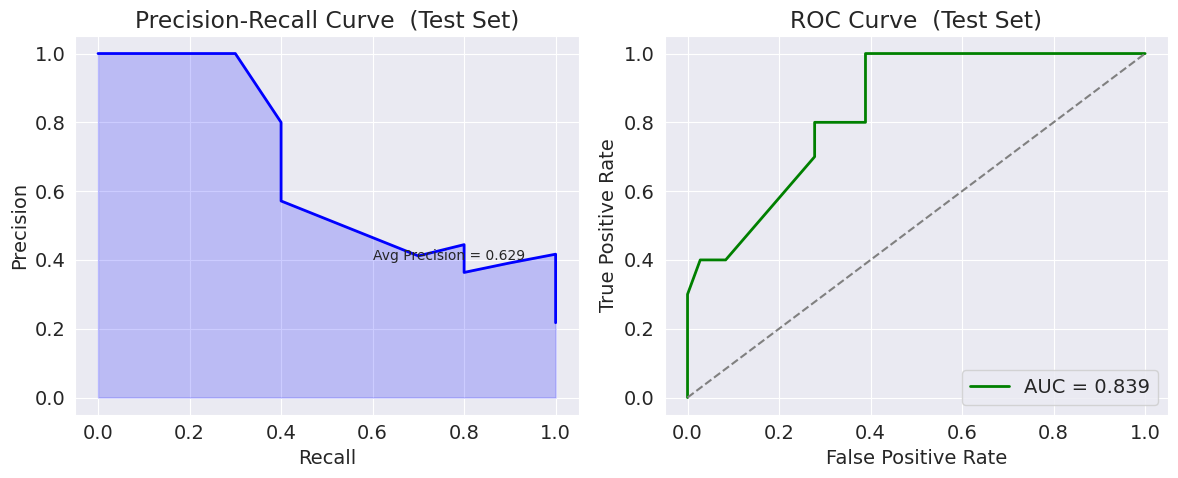

In [88]:
y_true = test_targets
y_proba = calibrated_model.predict_proba(test_inputs_encoded)[:, 1]

plot_pr_roc_curves(y_true, y_proba, title_suffix=' (Test Set)')


In [89]:
def create_visualizations(model_results: Dict, feature_importance: pd.DataFrame):
    """Create visualization plots"""
    print("Creating visualizations...")

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Feature Importance Plot
    axes[0, 0].barh(range(len(feature_importance)), feature_importance['importance'])
    axes[0, 0].set_yticks(range(len(feature_importance)))
    axes[0, 0].set_yticklabels(feature_importance['feature'])
    axes[0, 0].set_xlabel('Importance')
    axes[0, 0].set_title('Top Feature Importance')
    axes[0, 0].invert_yaxis()

    # Confusion Matrix
    cm = model_results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0, 1])
    axes[0, 1].set_title('Confusion Matrix')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')

    # ROC Curve (placeholder - would need actual implementation)
    axes[1, 0].plot([0, 1], [0, 1], 'k--')
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC Curve')
    axes[1, 0].text(0.6, 0.4, f'AUC = {model_results["auc_score"]:.3f}', fontsize=12)

    # Prediction Distribution
    pred_probs = model_results['predicted_probabilities']
    axes[1, 1].hist(pred_probs, bins=20, alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Predicted Probabilities')

    plt.tight_layout()
    plt.show()

    return fig

Creating visualizations...


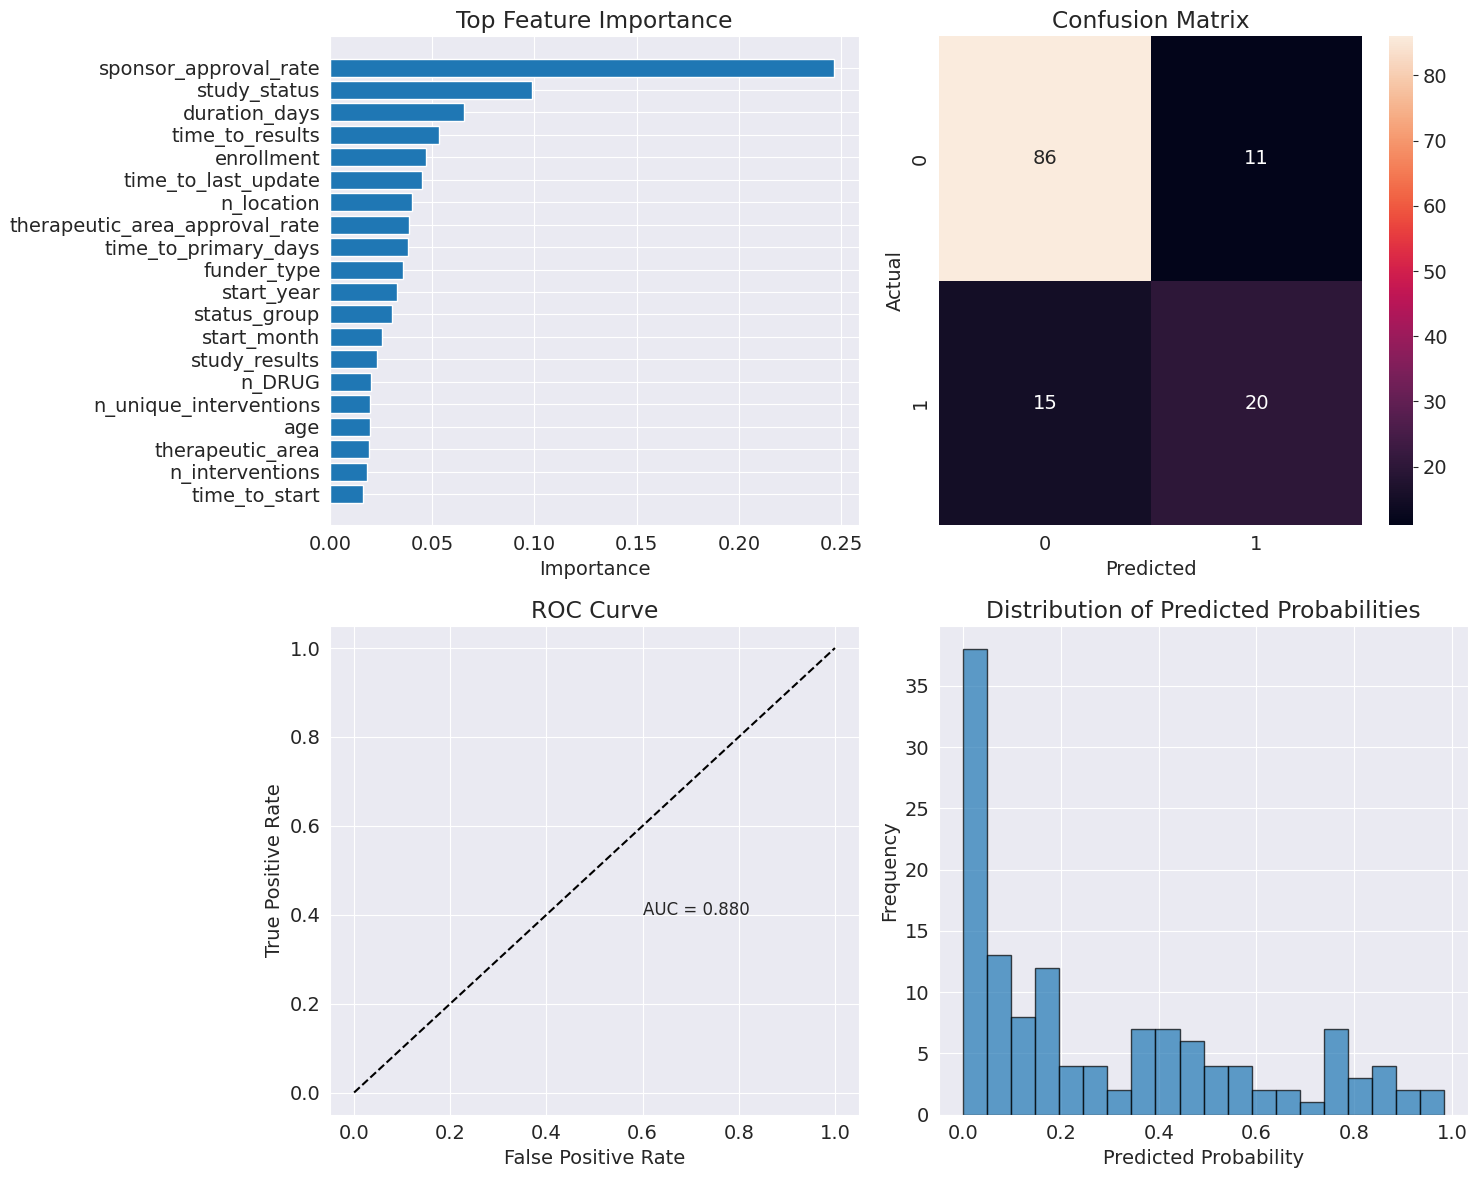

In [92]:
plot_fig = create_visualizations(evaluation_results, feature_importance)

### Interpretability

In [55]:
def get_feature_importance(model, feature_names: List[str], top_n: int = 20):
    """Get feature importance from the model"""

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    elif hasattr(model, 'estimators_'):  # For ensemble models
        # Get average importance from component models
        all_importances = []
        for estimator in model.estimators_:
            if hasattr(estimator, 'feature_importances_'):
                all_importances.append(estimator.feature_importances_)
            elif hasattr(estimator, 'coef_'):
                all_importances.append(np.abs(estimator.coef_[0]))

        if all_importances:
            importances = np.mean(all_importances, axis=0)
        else:
            importances = np.zeros(len(feature_names))
    else:
        importances = np.zeros(len(feature_names))

    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(top_n)

    return importance_df

In [90]:
feature_importance = get_feature_importance(best_model, X_resampled.columns.tolist())
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                           feature  importance
14           sponsor_approval_rate    0.246469
0                     study_status    0.098812
7                    duration_days    0.065650
10                 time_to_results    0.053333
4                       enrollment    0.046939
11             time_to_last_update    0.044795
15                      n_location    0.039854
29  therapeutic_area_approval_rate    0.038698
8             time_to_primary_days    0.037891
5                      funder_type    0.035707


## Save model

In [ ]:
import pickle

def save_model_to_pickle(model, filename: str = "final_model.pkl"):
    """
    Saves the trained model to a pickle file.

    Args:
        model: Trained model object (e.g., ensemble model).
        filename (str): Name of the pickle file to save the model.

    Returns:
        None
    """
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filename}")


In [ ]:
save_model_to_pickle(best_model, "final_model_06_18_2025.pkl")

Model saved to final_model_06_18_2025.pkl


## Generate PTS score

In [ ]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score

def get_pts_score(model, X_test, y_test=None):
    """
    Predicts PTS score using a trained model on the test set.

    Args:
        model: Trained classifier (e.g., calibrated ensemble).
        X_test (pd.DataFrame): Feature set for testing.
        y_test (pd.Series, optional): True labels, if available, to evaluate performance.

    Returns:
        np.ndarray: PTS scores (probabilities * 100).
    """
    probs = model.predict_proba(X_test)[:, 1]
    pts_scores = probs * 100

    if y_test is not None:
        recall = recall_score(y_test, probs > 0.5)
        f1 = f1_score(y_test, probs > 0.5)
        auc = roc_auc_score(y_test, probs)
        print(f"Test Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    return pts_scores


In [ ]:
final_test_data = pd.read_csv('/content/test_data.csv')

In [ ]:
final_test_data['PTS%'] = get_pts_score(best_model, final_test_data.drop(columns=['start_date']))

## LGBMClassifier

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

In [ ]:
clf = lgb.LGBMClassifier(n_estimators=150, learning_rate=0.05,max_depth=5, random_state=42)

In [ ]:
model1 = clf.fit(train_inputs_encoded, train_targets, eval_set=[(val_inputs_encoded, val_targets)])

[LightGBM] [Info] Number of positive: 366, number of negative: 508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1723
[LightGBM] [Info] Number of data points in the train set: 874, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.418764 -> initscore=-0.327848
[LightGBM] [Info] Start training from score -0.327848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [ ]:
PTS = model1.predict_proba(test_inputs_encoded)[:, 1]*100

In [ ]:
PTS

array([ 1.00486569, 29.59163046,  0.18907366,  1.31601535,  2.58110401,
        0.33519313, 95.90576683, 32.38172259,  5.26938358, 32.52285916,
        1.93325632,  0.36836067, 85.5642358 ,  0.76247197,  0.103272  ,
        0.1994091 ,  0.11565817,  0.26234839,  0.6158241 , 10.9826974 ,
        0.49097867,  0.25947142, 10.67259872,  0.42884274, 70.5233532 ,
       22.15108677,  2.07299577, 12.93704118, 18.40296932, 20.54594293,
       30.12593953,  0.88149668, 23.93194051, 21.82178603,  0.11188451,
       13.16855861,  0.81473467, 18.52135276,  1.00344107,  1.90599862,
       79.25848506,  1.13138097,  3.99965109, 77.30474947, 20.29268721,
       90.03250026])

In [ ]:
from sklearn.metrics import recall_score, f1_score, roc_auc_score, precision_score

def evaluate_classifier(clf, X, y, label='test', threshold=0.5):
    """
    Evaluate a binary classifier:
      - Recall
      - F1‑score
      - ROC AUC

    Parameters
    ----------
    clf : fitted classifier supporting predict_proba
    X   : feature DataFrame or array
    y   : true binary target array or Series
    label : str
      Name to tag the output (e.g. 'train' or 'test')
    threshold : float, default 0.5
      Probability cutoff for converting to class predictions

    Returns
    -------
    probs : numpy array
      Predicted probability of the positive class
    """
    # 1) get positive‑class probabilities
    probs = clf.predict_proba(X)[:, 1]

    # 2) convert to binary predictions
    preds = (probs > threshold).astype(int)

    # 3) compute metrics
    rec = recall_score(y, preds)
    prec = precision_score(y, preds)
    auc = roc_auc_score(y, probs)

    # 4) print results
    print(f'{label} Recall: {rec:.4f}, Prec‑score: {prec:.4f}, AUC: {auc:.4f}')

    return probs


In [ ]:
train_result = evaluate_classifier(model1, train_inputs_encoded, train_targets, label='train')

train Recall: 0.9454, Prec‑score: 0.9479, AUC: 0.9916


In [ ]:
val_result = evaluate_classifier(model1, val_inputs_encoded, val_targets, label='validation')

validation Recall: 0.5429, Prec‑score: 0.7917, AUC: 0.9278


In [ ]:
test_result = evaluate_classifier(model1, test_inputs_encoded, test_targets, label='test')

test Recall: 0.4000, Prec‑score: 0.6667, AUC: 0.8722
